# **Text Classification of Product Descriptions Using TF-IDF and Log Loss Optimization**

The aim of this work is to perform text preprocessing and **TF-IDF analysis** on **product ID** descriptions, which are associated with a total of **16 distinct labels**. The goal is to identify the model that, using TF-IDF features, **minimizes the log loss**.

The labeled dataset contains product metadata including **product IDs**, **text descriptions**, **class labels**, and, when available, **prices**. Below is a sample of the labeled set:

<div>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>product_id</th>
      <th>description</th>
      <th>label</th>
      <th>price</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>145598</th>
      <td>12805</td>
      <td>mlb san francisco giants baseball pet collar reflective</td>
      <td>7</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>145599</th>
      <td>153531</td>
      <td>daiwa ecxhfb emcast surf rod cast foot extra heavy piece pound emcast offer broad selection unique rod action cover wide variety specific fishing condition xtube blank protection prevent scratch wear rod rod holder cast rodfeet extra heavy piece pound</td>
      <td>2</td>
      <td>149.95</td>
    </tr>
    <tr>
      <th>145600</th>
      <td>137219</td>
      <td>speedo splatter silicone cap swimmer choose speedo swim cap brand world artsy graphic print cap make soft silicone insure comfort durability day wear easy pull hair pvc free great choice recreational competitive swimmer</td>
      <td>4</td>
      <td>9.99</td>
    </tr>
    <tr>
      <th>145601</th>
      <td>111672</td>
      <td>wingflyer z classic white</td>
      <td>9</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>145602</th>
      <td>223512</td>
      <td>condor tactical leg holster condor tactical leg holsterquickly draw pistol intense situation leg holster condorfeature</td>
      <td>2</td>
      <td>18.50</td>
    </tr>
  </tbody>
</table>
</div>

This table illustrates the structure of the input data used to train and evaluate the classification models. Including product descriptions and prices (where available) helps contextualize the features used during TF-IDF vectorization and model learning.

---

# Load-Preprocess-Analyse the necessary files

### Load Files

In [2]:
import csv
import numpy as np
import pandas as pd

- The **first step** is to load all the files associated with the project:
   1. the text file that contains the **descriptions** associated with the products' ids
   2. the text file that contains the **prices** of the product ids
   3. the **graph** that contains nodes corresponding to products & edges between two products indicating that the two products are
   frequently co-viewed by users.
   4. **unlabeled test set**, which will be used in the competition for the evaluations
   5. The **labeled train set**, which contains the product ids with the labels they belong in.
   6. **Merge** in the train set (`y_train`) the **descriptions** of the product ids.




In [3]:
descriptions = dict()
with open(r"/description.txt", "r") as f:
    for line in f:
        t = line.split('|=|')
        descriptions[int(t[0])] = t[1][:-1]

import pandas as pd
# Show full string content in all DataFrame cells
pd.set_option('display.max_colwidth', None)

# File paths
file= '/description.txt'
# Function to load and parse one file
def load_descriptions(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if '|=|' in line:
                product_id, text = line.strip().split('|=|', 1)
                data.append((product_id.strip(), text.strip()))
    return pd.DataFrame(data, columns=['product_id', 'title_description'])

# Load and combine both files into a single DataFrame
combined_df = load_descriptions(file)

# Final DataFrame
combined_df[:1]


,product_id,title_description
0,0,"FSA Orbit 1.5ZS Zero Stack Internal Bicycle Headset Internal headset (with cups) with angular contact bearings. 1.5"" / 1-1/8"" Steerer. 36/ 45 ACB. For tapered 50mm /62mm OD headtube. For 1-1/8"" fork steerer. Alloy top cap. Upper: Forged alloy cup with Angular Contact Bearings. Lower: 1.5"" CNC machined alloy cup with Angular Contact Bearings. Stack Height 16.9+2.9=19.8mm. 144 g"


In [4]:
price = dict()
with open(r"/price.txt", "r") as f:
    for line in f:
        t = line.split(',')
        #price[int(t[0])] = t[1][:-1]
        price[int(t[0])] = float(t[1].strip())

In [5]:
import networkx as nx

# Create an undirected graph
G = nx.read_edgelist('/edgelist.txt', delimiter=',', create_using=nx.Graph(), nodetype=int)
n = G.number_of_nodes()
m = G.number_of_edges()
print('Number of nodes:', n)
print('Number of edges:', m)


Number of nodes: 276453
Number of edges: 1811087


- load the **unlabeled test set**

In [6]:
# Read test data
test_data = list()
with open("/test.txt", "r") as f:
    for i,line in enumerate(f):
        t = line.split(',')
        test_data.append(int(t[0]))


- check the **type** of the unlabeled test set

In [7]:
print(type(test_data))


<class 'list'>


- load the **labeled set**

In [8]:
# Read the file into a DataFrame
y_train_df = pd.read_csv('/y_train.txt', sep=',', header=None, names=['product_id', 'label'])
# Display the shape and first few rows
print(f"Loaded {y_train_df.shape[0]} rows.")
y_train_df[:5]

Loaded 182006 rows.


,product_id,label
0,66795,9
1,242781,3
2,91280,2
3,56356,5
4,218494,0


In [9]:
# Ensure 'product_id' is int64 in both DataFrames
y_train_df['product_id'] = y_train_df['product_id'].astype(int)
combined_df['product_id'] = combined_df['product_id'].astype(int)

# Now perform the merge
merged_df = y_train_df.merge(combined_df, on='product_id', how='left')

# Show shape and preview
print(f"Merged DataFrame has {merged_df.shape[0]} rows.")
merged_df.head()


Merged DataFrame has 182006 rows.


,product_id,label,title_description
0,66795,9,"Pro-tec Classic Skate Independent Skateboard Helmet Often imitated, never duplicated that's the Classic Pro-Tec helmet. Our 2 stage soft foam liner and the newly added EVA crown pad keep things comfortable and lightweight, making this the style of choice season after season."
1,242781,3,Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY GOLF TOUR STAFF BAG RAZR BLACK RED 11
2,91280,2,"Heckler and Koch Entourage Knife Combo with Edged BK Coated Blade (Black, 8.44-Inch) For more than a half century, Heckler and Koch has been a leading designer and manufacturer of military, law enforcement and civilian firearms. HK&#x2019;s commitment to quality, innovation and safety make them an industry leader in reliability and technology. The Mini Entourage Series are new auto with enlarged push button and are made of integrated safety 440C stainless steel, flat grind tanto blade. Enhanced spring design for improved response time. 6061-T6 black anodized hard aluminum handle with reversible tip-up pocket clip . The combo-edged blade has blade length of 3.74-Inch and the overall length is 8.44-Inch."
3,56356,5,"Reelight Sl120 Flashing Extended Bicycle Headlight and Tail Light Set The Reelight SL120 Extended uses high power, ultra bright LED bulbs. Fits on most bicycles with roller and disc brakes. ( maximum diameter of 160mm/6"" ) The front and rear lights are flashing when the wheel is in motion. Features a capacitor to retain a two minute charge while the bicycle is stopped."
4,218494,0,Columbia Boys 8-20 Bug Shield Pant


---

# 1.  Lemmatization-Centric Text Normalization Pipeline- **Optimal Data Preprocess**

This preprocessing strategy **aggressively standardizes text by applying full lemmatization and cleanup** to reduce vocabulary complexity. It is tailored for models that benefit from a highly **normalized, compact token space**, such as linear classifiers or TF-IDF-based pipelines. By removing digits, punctuation, and stop words, and replacing inflected forms with their **base lemmas**, this approach focuses on **semantic generalization** over token richness.

### Train-Test(Labeled & Unlabeled) Preprocess

- `multiclass_log_loss` : This function calculates the **multiclass log loss**, a performance metric that measures how well predicted probabilities align with the true class labels. 

In [10]:
from sklearn.preprocessing import label_binarize

def multiclass_log_loss(y_true, y_pred_proba, eps=1e-15):
    """
    y_true: array-like of shape (N,) - true class labels
    y_pred_proba: array-like of shape (N, C) - predicted class probabilities
    """
    # Number of samples
    N = y_true.shape[0]

    # One-hot encode the true labels (yij)
    y_true_one_hot = label_binarize(y_true, classes=np.arange(y_pred_proba.shape[1]))

    # Clip predicted probabilities to avoid log(0)
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)

    # Compute the log loss
    loss = -np.sum(y_true_one_hot * np.log(y_pred_proba)) / N
    return loss


In [47]:
import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Full NLP preprocessing function with lemmatization
def clean_text_with_lemma(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Use spaCy to tokenize and lemmatize
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() for token in doc
        if token.lemma_.lower() not in STOP_WORDS
        and not token.is_punct
        and not token.is_space
        and not token.like_num
    ]

    return ' '.join(tokens)


- The **next step** is to load the **preprocessed labeled train and test sets** which have been splitted with stratifying method using the preprocessing function `clean_text_with_lemma`:

In [11]:
from IPython.display import display, HTML
import pandas as pd

train_df = pd.read_csv(r'/train.csv')
test_df = pd.read_csv(r'/test.csv')

- check for missing values in train and test set

In [12]:
# Find rows with missing 'description' in train_df
missing_train = train_df[train_df['text_clean'].isnull()]

# Find rows with missing 'description' in test_df
missing_test = test_df[test_df['text_clean'].isnull()]

# Print the rows with missing values
print("Rows with missing 'description' in train_df:")
print(missing_train)

print("\nRows with missing 'description' in test_df:")
print(missing_test)


Rows with missing 'description' in train_df:
       product_id text_clean  label
89285      265165        NaN      7

Rows with missing 'description' in test_df:
       product_id text_clean  label
34767      174103        NaN      5


- remove missing values

In [13]:
# Remove rows with missing 'description' in train_df
train_df = train_df.dropna(subset=['text_clean'])

# Remove rows with missing 'description' in test_df
test_df = test_df.dropna(subset=['text_clean'])

# Verify if any rows with missing values remain
print("Missing values in cleaned train_df:", train_df.isnull().sum())
print("Missing values in cleaned test_df:", test_df.isnull().sum())


Missing values in cleaned train_df: product_id    0
text_clean    0
label         0
dtype: int64
Missing values in cleaned test_df: product_id    0
text_clean    0
label         0
dtype: int64


- reset index after removing missing values

In [14]:
# Reset the index after removing rows with missing values
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
display(train_df.tail(5))

,product_id,text_clean,label
145592,12805,san francisco giants baseball pet collar reflective,7
145593,153531,daiwa ecxhfb surf rod foot extra heavy piece pound emcast broad selection unique rod action wide variety specific fishing condition xtube blank protection rod rod holder extra heavy piece pound,2
145594,137219,speedo splatter silicone cap swimmer speedo swim cap brand world artsy graphic print cap soft silicone comfort durability day easy hair pvc free great choice recreational competitive swimmer,4
145595,111672,wingflyer z classic white,9
145596,223512,condor tactical leg holster condor tactical leg pistol intense situation leg holster condorfeature,2


- load & apply the preprocess function (`clean_text_with_lemma`) on the **unlabeled test set**

In [48]:
# Retrieve descriptions of products in the test set
test_text = list()
for i in test_data:
    test_text.append(descriptions[i])

test_text[:1]

# Apply the cleaning function to each item in the list
test_text_cleaned = [clean_text_with_lemma(text) for text in test_text]

In [ ]:
test_text_cleaned[:2]

['geigerrig guardian rig tactical hydration pack compatible geigerrig plugnplay inline water filter l oz pressurize hydration engine corduraplate increase spray psidecrease pack profilegreat impact absorptionprotectionslidetop bladder easy refill clean dryingdring assist attach gear load vest armor etcstowable pack strap compression strap provide low profile high pressure spraymolle attachment loop strip backdimension x inch',
 'tall scooter cc street legal free matching helmet engine size stroke single cylinder cc hp cool air cool transmission fully automatic drive cvt starter electric key kick start ignition cdi speed mph suspension hydraulic rear suspension hydraulic spring brake hydraulic disc rear brake mechanical drum tire inch rear tire inch wheel base control twist throttle fully automatic lighting headlight brake light blinker fully street l weight capacity lbs dry weight length width height seat height']

In [ ]:
import pandas as pd

df_test_un = pd.DataFrame({
    'product_id': test_data,
    'cleaned_description': test_text_cleaned,
    'price': [price.get(pid, 0.0) for pid in test_data]  # fallback if price is missing
})

df_test_un[:2]

,product_id,cleaned_description,price
0,49957,geigerrig guardian rig tactical hydration pack compatible geigerrig plugnplay inline water filter l oz pressurize hydration engine corduraplate increase spray psidecrease pack profilegreat impact absorptionprotectionslidetop bladder easy refill clean dryingdring assist attach gear load vest armor etcstowable pack strap compression strap provide low profile high pressure spraymolle attachment loop strip backdimension x inch,133.0
1,135386,tall scooter cc street legal free matching helmet engine size stroke single cylinder cc hp cool air cool transmission fully automatic drive cvt starter electric key kick start ignition cdi speed mph suspension hydraulic rear suspension hydraulic spring brake hydraulic disc rear brake mechanical drum tire inch rear tire inch wheel base control twist throttle fully automatic lighting headlight brake light blinker fully street l weight capacity lbs dry weight length width height seat height,749.0


### Exploratory Data Analysis: Label Distribution and Text Statistics

- Visualized the **distribution of product labels** in both training and test sets using side-by-side bar plots to assess class balance.
- Computed **word frequency** statistics on product descriptions in the training data, identifying the number of words occurring more than 5 times to understand vocabulary richness.
- Calculated the **average number of tokens per description**, providing insight into the typical length of textual data for downstream preprocessing and modeling.


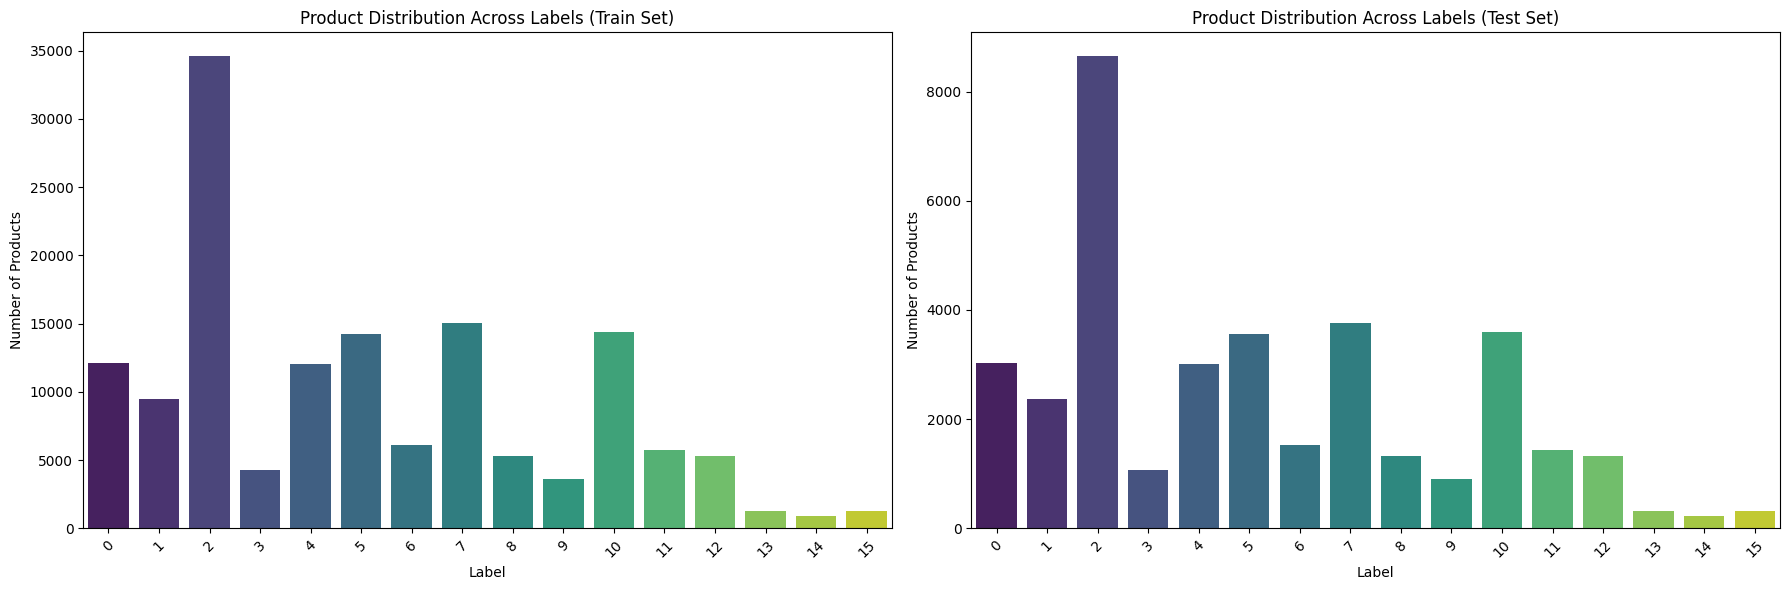

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

label_counts_train = train_df['label'].value_counts().sort_index()  # Sort by label to ensure 0, 1, 2... order
label_counts_test = test_df['label'].value_counts().sort_index()  # Sort by label to ensure 0, 1, 2... order

# Create a bar plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot for Train Set
sns.barplot(x=label_counts_train.index, y=label_counts_train.values, palette='viridis', ax=axes[0], hue=None)
axes[0].set_title('Product Distribution Across Labels (Train Set)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Number of Products')
axes[0].tick_params(axis='x', rotation=45)

# Plot for Test Set
sns.barplot(x=label_counts_test.index, y=label_counts_test.values, palette='viridis', ax=axes[1], hue=None)
axes[1].set_title('Product Distribution Across Labels (Test Set)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Number of Products')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
from collections import Counter

all_words = " ".join(train_df['description'].dropna()).split()
word_freq = Counter(all_words)

# How many words occur more than 5 times?
common_words = [word for word, count in word_freq.items() if count > 5]
print(f"Words occurring more than 5 times: {len(common_words)}")


Words occurring more than 5 times: 33033


In [ ]:
token_counts = train_df['description'].dropna().apply(lambda x: len(x.split()))
avg_tokens = token_counts.mean()
print(f"Average number of tokens per description: {avg_tokens:.2f}")


Average number of tokens per description: 45.89


# 1.2 Baseline TF-IDF Representation: Unigrams and Bigrams

In this experiment, a **TF-IDF vectorizer** was used with **unigram and bigram n-grams (1,2)**, a **minimum document frequency of 5**, and a **maximum document frequency of 0.95**.  
This setup captures both individual words and frequent word pairs while filtering out rare and overly common terms.  
The resulting **TF-IDF matrix was used as the primary feature representation** for both the labeled training and test datasets.


- At this step, we **splitted** the datasets (`train_df` & `test_df`) to respectively:
    - `X_train` & `X_test`: containing the **descriptions** of the product ids.
    - `y_train` & `y_test`: containing the **labels** of the product ids.

In [15]:
X_train = train_df['text_clean']
y_train = train_df['label']

X_test = test_df['text_clean']
y_test = test_df['label']

In [ ]:
y_train.unique()

array([ 2, 11,  7, 10,  3, 15,  6,  5,  0,  1,  4, 12,  8,  9, 14, 13])

- Then, we defined the `TfidfVectorizer`. After experimenting with various parameter combinations, we selected the following configuration, which provided a good balance        between capturing informative patterns and minimizing noise:
    - `ngram_range=(1,2)` : Captures both unigrams (single words) and bigrams (two-word combinations)
    - `min_df=5` : Terms that appear in fewer than 5 documents are ignored.
    - `max_df=0.95` : Terms that appear in more than 95% of the documents are also ignored.
    - `sublinear_tf=True`: Applies sublinear term frequency scaling to reduce the impact of very frequent terms.
    - `norm='l2'`: Normalizes the resulting vectors using L2 norm to standardize their magnitude.

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95, sublinear_tf=True, norm='l2')

# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train) # labeled train set
X_tfidf_test = tfidf_vectorizer.transform(X_test) # labeled test set
X_tfidf_test_comp =  tfidf_vectorizer.transform(test_text_cleaned) # unlabeled test set

### Logistic Regression Classification on TF-IDF Features

This experiment trains a **Logistic Regression** model using the **'saga' solver** and a maximum of 5000 iterations for convergence.  
The model is fit on the TF-IDF-transformed training data and evaluated on the test set.  


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# Initialize and train the model
lr_model = LogisticRegression(solver='saga', max_iter=5000, random_state=42)
lr_model.fit(X_tfidf_train, y_train)

# Make predictions and evaluate
y_pred = lr_model.predict(X_tfidf_test)
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred))


Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3033
           1       0.89      0.87      0.88      2372
           2       0.89      0.96      0.92      8652
           3       0.95      0.93      0.94      1073
           4       0.93      0.92      0.92      3016
           5       0.94      0.95      0.94      3564
           6       0.94      0.91      0.92      1519
           7       0.96      0.92      0.94      3752
           8       0.96      0.93      0.94      1316
           9       0.95      0.88      0.91       903
          10       0.86      0.86      0.86      3589
          11       0.90      0.88      0.89      1425
          12       0.90      0.76      0.82      1318
          13       0.91      0.77      0.84       323
          14       1.00      0.85      0.92       226
          15       0.98      0.84      0.90       320

    accuracy                        

- Results of **Logistic Regression** and **TF-IDF** on `train_set`

In [ ]:
# Predict probabilities
y_proba = lr_model.predict_proba(X_tfidf_test)

# Compute custom log loss
custom_loss = multiclass_log_loss(y_test, y_proba)
print(f"Manual Log Loss: {custom_loss:.4f}")


Manual Log Loss: 0.3680


- Results of **Logistic Regression** and **TF-IDF** on `train_set`

In [ ]:
# Predict probabilities
y_proba_train = lr_model.predict_proba(X_tfidf_train)

# Compute custom log loss
custom_loss_lg_train = multiclass_log_loss(y_train, y_proba_train)
print(f"Manual Log Loss: {custom_loss:.4f}")


Manual Log Loss: 0.2888


### Calibrated LinearSVC Classification on TF-IDF Features

This experiment employs a **Linear Support Vector Classifier (LinearSVC)** wrapped in a **CalibratedClassifierCV** for probability calibration using Platt scaling with 5-fold cross-validation.  This wrapper applies probability calibration using **isotonic regression** (rather than Platt scaling), ensuring that the output probabilities better reflect the true likelihoods of class membership.

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report

- Results of **SVM** and **TF-IDF** on `train_set`

In [ ]:
y_proba_svm_train = svm_model.predict_proba(X_tfidf_train)

# Compute custom log loss
custom_loss_svm_train = multiclass_log_loss(y_train, y_proba_svm_train)
print(f"Probabilistic Log Loss-Train Set (SVM): {custom_loss_svm_train:.4f}")

Probabilistic Log Loss-Train Set (SVM): 0.0777


- Results of **SVM** and **TF-IDF** on `test_set`

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_svm = LinearSVC(max_iter=5000)
svm_model = CalibratedClassifierCV(base_svm, cv=cv, method='isotonic')# Platt scaling internally

svm_model.fit(X_tfidf_train, y_train)

y_pred_svm = svm_model.predict(X_tfidf_test)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm))


y_proba_svm = svm_model.predict_proba(X_tfidf_test)

# Compute custom log loss
custom_loss_svm = multiclass_log_loss(y_test, y_proba_svm)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm:.4f}")


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.91      0.90      0.90      2372
           2       0.93      0.95      0.94      8652
           3       0.96      0.97      0.96      1073
           4       0.94      0.95      0.94      3016
           5       0.96      0.96      0.96      3564
           6       0.94      0.94      0.94      1519
           7       0.97      0.93      0.95      3752
           8       0.96      0.96      0.96      1316
           9       0.96      0.93      0.95       903
          10       0.89      0.88      0.88      3589
          11       0.92      0.93      0.93      1425
          12       0.90      0.83      0.86      1318
          13       0.91      0.87      0.89       323
          14       0.96      0.96      0.96       226
          15       0.95      0.95      0.95       320

    accuracy                           0.94    

- Write Class Probabilities for the **Unlabeled Set** Using **SVM** & **TF-IDF** and Save to CSV

In [ ]:
y_proba_svm_comp = svm_model.predict_proba(X_tfidf_test_comp)

import csv
with open('/best_svm_tfidf.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_proba_svm_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

### Random Forest Classifier on Combined Features

A **Random Forest** classifier with 100 trees is trained on combined feature representations.  
The model leverages all CPU cores for parallel training and allows trees to grow fully (no max depth limit).  
These **hyperparameters** were selected because they consistently yielded the **best validation performance**—alternative configurations tended to overfit the training set, compromising generalization to unseen data.

- Classification Report & logloss result of **Random Forest** and **TF-IDF** on `test_set`

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import cross_val_score

# 1. Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    max_depth=None         # Let the trees grow fully (adjustable)
)

# 2. Fit the model
rf_model.fit(X_tfidf_train, y_train)

# 3. Predict class probabilities for log loss
y_proba_rf = rf_model.predict_proba(X_tfidf_test)

# 4. Predict class labels for classification report
y_pred_rf = rf_model.predict(X_tfidf_test)

# 5. Evaluate
print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))

# 6. Log Loss (for competition)
custom_loss_rf = multiclass_log_loss(y_test, y_proba_rf)
print(f"Probabilistic Log Loss (RandomForest): {custom_loss_rf:.4f}")

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3033
           1       0.91      0.82      0.86      2372
           2       0.83      0.96      0.89      8652
           3       0.96      0.93      0.94      1073
           4       0.93      0.87      0.90      3016
           5       0.91      0.95      0.93      3564
           6       0.94      0.88      0.91      1519
           7       0.96      0.93      0.94      3752
           8       0.96      0.89      0.93      1316
           9       0.95      0.88      0.91       903
          10       0.86      0.80      0.83      3589
          11       0.91      0.85      0.88      1425
          12       0.93      0.73      0.82      1318
          13       0.92      0.65      0.76       323
          14       0.99      0.86      0.92       226
          15       0.96      0.75      0.84       320

    accuracy                           0.9

- Results of **Random Forest** and **TF-IDF** on `train_set`

In [ ]:
y_proba_rf_train = rf_model.predict_proba(X_tfidf_train)

# Compute custom log loss
custom_loss_rf_train = multiclass_log_loss(y_train, y_proba_rf_train)
print(f"Probabilistic Log Loss (RF-TRAIN): {custom_loss_rf_train:.4f}")
all_results_train.append({'model': 'RandomForest', 'log_loss': custom_loss_rf_train})

Probabilistic Log Loss (RF-TRAIN): 0.1222


### XGBoost Classifier on TF-IDF Features

An **XGBoost** classifier configured for multiclass classification is trained on TF-IDF features.
Key hyperparameters include `n_estimators=100`, a `max_depth=6`, and a `learning_rate=0.1`. The model uses multiclass log loss (`mlogloss`) as the evaluation metric, runs in parallel across all CPU cores, and is initialized with a fixed random seed for reproducibility.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, log_loss

# 1. Initialize the model
xgb_model = XGBClassifier(
    objective='multi:softprob',  # Needed for multiclass probability output
    num_class=len(np.unique(y_train)),  # Set number of classes
    eval_metric='mlogloss',  # Use multiclass log loss as eval metric
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# 2. Train the model
xgb_model.fit(X_tfidf_train, y_train)

# 3. Predict probabilities and labels
y_proba_xgb = xgb_model.predict_proba(X_tfidf_test)
y_pred_xgb = xgb_model.predict(X_tfidf_test)

# 4. Evaluation
print("XGBoost - Classification Report")
print(classification_report(y_test, y_pred_xgb))

# 5. Log loss
loss_xgb = multiclass_log_loss(y_test, y_proba_xgb)
print(f"XGBoost - Multiclass Log Loss: {loss_xgb:.4f}")


XGBoost - Classification Report
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3033
           1       0.87      0.78      0.82      2372
           2       0.71      0.94      0.81      8652
           3       0.94      0.92      0.93      1073
           4       0.91      0.76      0.83      3016
           5       0.91      0.85      0.88      3564
           6       0.94      0.82      0.87      1519
           7       0.94      0.86      0.90      3752
           8       0.93      0.85      0.89      1316
           9       0.92      0.85      0.89       903
          10       0.85      0.68      0.76      3589
          11       0.90      0.80      0.85      1425
          12       0.91      0.72      0.80      1318
          13       0.83      0.79      0.81       323
          14       0.97      0.92      0.94       226
          15       0.96      0.77      0.85       320

    accuracy                           0.84     

- Results of **XGBoost** and **TF-IDF** on `train_set`

In [ ]:
y_proba_xb_train = xgb_model.predict_proba(X_tfidf_train)

# Compute custom log loss
custom_loss_xgb_train = multiclass_log_loss(y_train, y_proba_xb_train)
print(f"Probabilistic Log Loss (XGB-TRAIN): {custom_loss_xgb_train:.4f}")
all_results_train.append({'model': 'XGBoost', 'log_loss': custom_loss_xgb_train})

Probabilistic Log Loss (XGB-TRAIN): 0.5581


### Hyperparameter Tuning for Calibrated LinearSVC using GridSearchCV

As a next step, we performed a grid search over **C** and **loss** parameters of a LinearSVC wrapped in a **CalibratedClassifierCV** for probabilistic calibration.  
Used 5-fold cross-validation optimizing for negative log loss to find the best parameters.  


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Define base model
base_svm = LinearSVC(max_iter=1000)

# Wrap in CalibratedClassifierCV
calibrated_svm = CalibratedClassifierCV(estimator=base_svm, cv=3)

# Define parameter grid using 'estimator__' prefix
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__loss': ['hinge', 'squared_hinge']
}

# Use GridSearchCV
grid_search = GridSearchCV(calibrated_svm, param_grid, cv=5, scoring='neg_log_loss', n_jobs=-1)

# Fit to data
grid_search.fit(X_tfidf_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best log loss:", -grid_search.best_score_)


Best parameters: {'estimator__C': 1, 'estimator__loss': 'squared_hinge'}
Best log loss: 0.27203531784274526


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm_tune = LinearSVC(C=1, loss='squared_hinge', max_iter=1000)

svm_model_tune = CalibratedClassifierCV(base_svm_tune, cv=3)  # Platt scaling internally

svm_model_tune.fit(X_tfidf_train, y_train)

y_pred_svm_tune = svm_model_tune.predict(X_tfidf_test)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm_tune))


y_proba_svm_tune = svm_model_tune.predict_proba(X_tfidf_test)


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.91      0.90      0.91      2372
           2       0.92      0.95      0.93      8652
           3       0.96      0.96      0.96      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3565
           6       0.95      0.94      0.94      1519
           7       0.96      0.94      0.95      3752
           8       0.97      0.95      0.96      1316
           9       0.95      0.93      0.94       903
          10       0.89      0.88      0.88      3589
          11       0.92      0.92      0.92      1425
          12       0.89      0.81      0.85      1318
          13       0.91      0.86      0.89       323
          14       0.97      0.95      0.96       226
          15       0.96      0.93      0.94       320

    accuracy                           0.93    

- Results **of tuning SVM with GridSearchSV** and **TF-IDF** on `test_set`

In [ ]:
# Compute custom log loss
custom_loss_svm_tune = multiclass_log_loss(y_test, y_proba_svm_tune)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm_tune:.4f}")

Probabilistic Log Loss (SVM): 0.2551


### Soft Voting Ensemble of Calibrated SVM, Naive Bayes, and Logistic Regression

Combined **Calibrated LinearSVC** and **Logistic Regression** in a soft **voting ensemble** to leverage diverse model strengths.  
The ensemble was trained on **TF-IDF features** and evaluated with classification metrics and probabilistic log loss on the test set, aiming to improve overall predictive performance through model averaging.


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Base models
svc = LinearSVC(max_iter=5000)
calibrated_svc = CalibratedClassifierCV(svc, cv=7)  # Needed for predict_proba


rf = RandomForestClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(solver='saga', max_iter=5000, random_state=42)

# Create a soft voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('svc', calibrated_svc),
        ('lr', lr)
    ],
    voting='soft',  # Use probabilities for voting
    weights=[5,1]  # Give svc twice the influence
)

# Fit ensemble on training data
voting_clf.fit(X_tfidf_train, y_train)

# Predictions
y_pred = voting_clf.predict(X_tfidf_test)
print("\nVoting Classifier Final Test Set Performance:")
print(classification_report(y_test, y_pred))

# Probability predictions
y_proba_voting = voting_clf.predict_proba(X_tfidf_test)


# Compute custom log loss
custom_loss_voting = multiclass_log_loss(y_test, y_proba_voting)
print(f"Probabilistic Log Loss-Test (voting): {custom_loss_voting:.4f}")

# Probability predictions
y_proba_voting_train = voting_clf.predict_proba(X_tfidf_train)


# Compute custom log loss
custom_loss_voting_train = multiclass_log_loss(y_train, y_proba_voting_train)
print(f"Probabilistic Log Loss-Train (voting): {custom_loss_voting_train:.4f}")


Voting Classifier Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.91      0.91      0.91      2372
           2       0.92      0.95      0.93      8652
           3       0.96      0.96      0.96      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3564
           6       0.95      0.94      0.95      1519
           7       0.96      0.94      0.95      3752
           8       0.97      0.95      0.96      1316
           9       0.96      0.93      0.94       903
          10       0.88      0.88      0.88      3589
          11       0.92      0.92      0.92      1425
          12       0.89      0.82      0.85      1318
          13       0.91      0.86      0.89       323
          14       0.98      0.96      0.97       226
          15       0.96      0.93      0.94       320

    accuracy                     

### Sematic Feature

This pipeline combines **TF-IDF** (unigrams and bigrams) with **semantic sentence embeddings** (`all-mpnet-base-v2`) to capture both lexical and contextual features of the text. The combined feature set is then used to train a **calibrated Linear SVM**, allowing for both classification and probability estimation. The final model is evaluated using multiclass **log loss**.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

X_embed_train = model.encode(X_train, convert_to_tensor=False)
X_embed_test = model.encode(X_test, convert_to_tensor=False)

# Concatenate TF-IDF with semantic embeddings
from scipy.sparse import hstack
X_comb_train = hstack([X_tfidf_train, X_embed_train])
X_comb_test = hstack([X_tfidf_test, X_embed_test])

X_embed_test_unlabeled = model.encode(test_text_cleaned, convert_to_tensor=False)
X_comb_test_unlabeled = hstack([X_tfidf_test_comp, X_embed_test_unlabeled])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#---------TRAIN BEST SVC-------------------------------------

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_svm2 = LinearSVC(max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm2, cv=cv, method='isotonic')# Platt scaling internally

svm_model2.fit(X_comb_train, y_train)

y_pred_svm2 = svm_model2.predict(X_comb_test)
print("\nSVM Final Test Set Performance:")


y_proba_svm2 = svm_model2.predict_proba(X_comb_test)

# Compute custom log loss
custom_loss_svm2 = multiclass_log_loss(y_test, y_proba_svm2)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm2:.4f}")


SVM Final Test Set Performance:
Probabilistic Log Loss (SVM): 0.2408


- Results of **SVM** and **TF-IDF Embeddings** on the `train_set`

In [ ]:
y_proba_svm2_train = svm_model2.predict_proba(X_comb_train)

# Compute custom log loss
custom_loss_svm2_train = multiclass_log_loss(y_train, y_proba_svm2_train)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm2_train:.4f}")

Probabilistic Log Loss (SVM): 0.0776


- Write Class Probabilities for the **Unlabeled** Set Using **SVM** and **TF-IDF Embeddings** and Save to CSV

In [ ]:
y_proba_svm_comp = svm_model2.predict_proba(X_comb_test_unlabeled)

import csv
with open('/best_svm_tfidf.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_proba_svm_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

### Multi-Layer Perceptron (MLP)



In [ ]:
import os
import torch
import seaborn as sns
import torch.nn as nn
import matplotlib.cm as cm
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import auc, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import issparse

 `SparseDataset_new` Class Overview

This custom PyTorch `Dataset` is designed to handle sparse input data (e.g., TF-IDF vectors) efficiently.

* **`__init__`**:

  * Converts the input `X` to **CSR format** (Compressed Sparse Row) if it is sparse, ensuring compatibility with row-based indexing.
  * Handles labels `y` as either a **Pandas Series**, PyTorch Tensor, or NumPy array.

* **`__len__`**:

  * Returns the total number of samples in the dataset.

* **`__getitem__`**:

  * Retrieves the feature vector and label for a given index `idx`.
  * Converts the sparse feature row to a dense PyTorch tensor.
  * Ensures labels are returned as PyTorch tensors (of type `long` for classification).

In [ ]:
class SparseDataset_new(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Ensure CSR format for safe indexing
        self.X = X.tocsr() if issparse(X) else X

        if isinstance(y, pd.Series):
            self.y = y.reset_index(drop=True)
        else:
            self.y = y  # Assume already tensor or compatible

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx].toarray(), dtype=torch.float32).squeeze(0)
        y = self.y[idx] if isinstance(self.y, torch.Tensor) else torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [ ]:
def train_model_mlp(model, train_loader, val_loader, criterion, optimizer,
                epochs=20, patience=5):
    train_losses, val_losses = [], []
    train_log_losses, val_log_losses = [], []
    best_val_loss = float('inf')
    best_model_path = None
    no_improvement_epochs = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_train_true, y_train_prob = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            probs = torch.softmax(y_pred, dim=1)
            y_train_true.extend(y_batch.cpu().tolist())
            y_train_prob.extend(probs.detach().cpu().tolist())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Log loss on training set
        y_train_true = np.array(y_train_true)
        y_train_prob = np.array(y_train_prob)
        train_log_loss = multiclass_log_loss(y_train_true, y_train_prob)
        train_log_losses.append(train_log_loss)

        # Validation
        model.eval()
        val_loss = 0
        y_val_true, y_val_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

                probs = torch.softmax(y_pred, dim=1)
                y_val_true.extend(y_batch.cpu().tolist())
                y_val_prob.extend(probs.cpu().tolist())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        y_val_true = np.array(y_val_true)
        y_val_prob = np.array(y_val_prob)
        val_log_loss = multiclass_log_loss(y_val_true, y_val_prob)
        val_log_losses.append(val_log_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train LogLoss: {train_log_loss:.4f} | Val LogLoss: {val_log_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_log_losses, val_log_losses


def evaluate_model_mlp(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []  # y_prob will store probabilities for ROC curve
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class (for metrics)

            y_true.extend(y_batch.tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())  # Store probabilities for ROC curve

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    return y_true, y_pred, y_prob

- Architecture of **MLP model (`CustomModel_MLP`)**

In [ ]:
class CustomModel_MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=None,
                 dropout=0.0, batch_norm=False, layer_norm=False,
                 classes_number=20, device=None):

        super(CustomModel_MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        if hidden_layers:
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                if batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                if layer_norm:
                    layers.append(nn.LayerNorm(hidden_dim))
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, classes_number))
        self.net = nn.Sequential(*layers)

        # Ensure the model is on the correct device
        if device:
            self.to(device)

    def forward(self, x):
        return self.net(x)

#### A. MLP with TFI-DF
As a next approach, we can explore using a **Multi-Layer Perceptron (MLP)** classifier trained on  **TF-IDF representations.**

- Splitting train set to validation and new training set.

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_tfidf_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train  # Ensures class distribution is preserved
)

y_train_split = y_train_split.reset_index(drop=True)
y_val_split = y_val_split.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


In [ ]:
# Create datasets for train, validation, and test
train_dataset = SparseDataset_new(X_train_split, y_train_split)
val_dataset = SparseDataset_new(X_val_split, y_val_split)
test_dataset = SparseDataset_new(X_tfidf_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

test_dataset_unlabeled = SparseDataset_new(X_tfidf_test_comp, torch.zeros(X_tfidf_test_comp.shape[0]))  # Dummy labels
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=64, shuffle=False)


# Re-initialize model per fold
model_mlp = CustomModel_MLP(
        input_dim=X_tfidf_train.shape[1],
        hidden_layers=[64],
        dropout=0.4,
        batch_norm=True,
        layer_norm=True,
        classes_number=len(np.unique(y_train_split)),
        device=device
    )


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss and optimizer (use class weights!)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.0001, weight_decay=1e-3)

# Train the model for this fold
train_losses, val_losses, train_log_losses, val_log_losses = train_model_mlp(
        model_mlp, train_loader, val_loader, criterion, optimizer, epochs=20, patience=2
    )


Epoch 1/20 | Train Loss: 0.5346 | Val Loss: 0.2838 | Train LogLoss: 0.5332 | Val LogLoss: 0.2844
Epoch 2/20 | Train Loss: 0.1472 | Val Loss: 0.2763 | Train LogLoss: 0.1463 | Val LogLoss: 0.2769
Epoch 3/20 | Train Loss: 0.0808 | Val Loss: 0.2978 | Train LogLoss: 0.0808 | Val LogLoss: 0.2984
Epoch 4/20 | Train Loss: 0.0675 | Val Loss: 0.3152 | Train LogLoss: 0.0672 | Val LogLoss: 0.3159
Early stopping triggered at epoch 4


In [ ]:
y_true, y_pred, y_prob = evaluate_model_mlp(model_mlp, test_loader)
test_mlp_logloss = multiclass_log_loss(y_test, y_prob)
print(f"Probabilistic Log Loss-Test Set (MLP-TFIDF): {test_mlp_logloss:.4f}")

print("\nMLP(TFIDF) Final Test Set Performance:")
print(classification_report(y_test, y_pred))



Probabilistic Log Loss-Test Set (MLP-TFIDF): 0.3174

MLP(TFIDF) Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3033
           1       0.89      0.88      0.89      2372
           2       0.91      0.94      0.92      8652
           3       0.96      0.94      0.95      1073
           4       0.93      0.92      0.93      3016
           5       0.95      0.95      0.95      3564
           6       0.93      0.94      0.93      1519
           7       0.95      0.93      0.94      3752
           8       0.97      0.93      0.95      1316
           9       0.94      0.92      0.93       903
          10       0.85      0.86      0.85      3589
          11       0.92      0.90      0.91      1425
          12       0.89      0.79      0.84      1318
          13       0.90      0.84      0.87       323
          14       0.98      0.92      0.95       226
          15       0.96      0.89      0.93

In [ ]:
y_true_comp, y_pred_comp, y_prob_comp = evaluate_model_mlp(model_mlp, test_loader_unlabeled)

import csv
with open('/mlp1.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_prob_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

#### B. MLP with TFIDF & EMBEDDINGS
Tehn, we used **Multi-Layer Perceptron (MLP)** classifier trained on the combination **TF-IDF representations** with **Embeddings**.

In [ ]:
from sklearn.model_selection import train_test_split
import torch

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_comb_train,
    y_train,
    test_size=0.2,
    random_state=42
    #stratify=y_train  # Ensures class distribution is preserved
)

y_train_split = y_train_split.reset_index(drop=True)
y_val_split = y_val_split.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import os

# Create datasets for train, validation, and test
train_dataset = SparseDataset_new(X_train_split, y_train_split)
val_dataset = SparseDataset_new(X_val_split, y_val_split)
test_dataset = SparseDataset_new(X_comb_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

test_dataset_unlabeled = SparseDataset_new(X_comb_test_unlabeled, torch.zeros(X_comb_test_unlabeled.shape[0]))  # Dummy labels
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=64, shuffle=False)


In [ ]:
# Re-initialize model per fold
model_mlp_emb = CustomModel_MLP(
        input_dim=X_comb_train.shape[1],
        hidden_layers=[256, 128, 64],
        dropout=0.4,
        batch_norm=True,
        layer_norm=True,
        classes_number=len(np.unique(y_train_split)),
        device=device
    )


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss and optimizer (use class weights!)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp_emb.parameters(), lr=0.00001, weight_decay=1e-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 20
patience = 2
train_losses, val_losses, train_log_losses, val_log_losses = train_model_mlp(
    model_mlp_emb,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs=20,
    patience=3
)


Epoch 1/20 | Train Loss: 1.4919 | Val Loss: 0.7120 | Train LogLoss: 1.4910 | Val LogLoss: 0.7124
Epoch 2/20 | Train Loss: 0.9038 | Val Loss: 0.5312 | Train LogLoss: 0.9037 | Val LogLoss: 0.5319
Epoch 3/20 | Train Loss: 0.6741 | Val Loss: 0.4556 | Train LogLoss: 0.6725 | Val LogLoss: 0.4563
Epoch 4/20 | Train Loss: 0.5443 | Val Loss: 0.4203 | Train LogLoss: 0.5437 | Val LogLoss: 0.4209
Epoch 5/20 | Train Loss: 0.4706 | Val Loss: 0.4069 | Train LogLoss: 0.4703 | Val LogLoss: 0.4075
Epoch 6/20 | Train Loss: 0.4247 | Val Loss: 0.4040 | Train LogLoss: 0.4246 | Val LogLoss: 0.4047
Epoch 7/20 | Train Loss: 0.3920 | Val Loss: 0.4045 | Train LogLoss: 0.3917 | Val LogLoss: 0.4052
Epoch 8/20 | Train Loss: 0.3741 | Val Loss: 0.4089 | Train LogLoss: 0.3738 | Val LogLoss: 0.4096
Epoch 9/20 | Train Loss: 0.3683 | Val Loss: 0.4199 | Train LogLoss: 0.3680 | Val LogLoss: 0.4206
Early stopping triggered at epoch 9


In [ ]:
y_true, y_pred, y_prob = evaluate_model_mlp(model_mlp_emb, test_loader)
test_mlp_logloss = multiclass_log_loss(y_test, y_prob)
print(f"Probabilistic Log Loss-Test Set (MLP-TFIDF & EMBEDDINGS): {test_mlp_logloss:.4f}")
print("\nMLP(TFIDF & EMBEDDINGS) Final Test Set Performance:")
print(classification_report(y_test, y_pred))



Probabilistic Log Loss-Test Set (MLP-TFIDF & EMBEDDINGS): 0.4063

MLP(TFIDF & EMBEDDINGS) Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3033
           1       0.89      0.90      0.89      2372
           2       0.90      0.95      0.92      8652
           3       0.97      0.95      0.96      1073
           4       0.94      0.93      0.93      3016
           5       0.94      0.96      0.95      3564
           6       0.95      0.93      0.94      1519
           7       0.95      0.94      0.95      3752
           8       0.96      0.95      0.95      1316
           9       0.94      0.91      0.93       903
          10       0.88      0.85      0.87      3589
          11       0.93      0.91      0.92      1425
          12       0.87      0.82      0.84      1318
          13       0.95      0.75      0.84       323
          14       0.99      0.86      0.92       226
          15     

In [ ]:
y_true_comp, y_pred_comp, y_prob_comp = evaluate_model_mlp(model, test_loader_unlabeled)


import csv
with open('/mlpembed_new.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_prob_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

# 2. TF-IDF Feature Selection Strategy: Reducing Dimensionality and Noise



In this setup, the **TF-IDF** features were carefully refined using feature selection with **SelectKBest (Chi², top 10,000 features)**. The goal was to **reduce dimensionality and noise**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, log_loss

# ======== TF-IDF Transformation ========
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),         # include unigrams + bigrams
    min_df=5,                   # remove rare terms
    max_df=0.85,                # remove overly common terms
    sublinear_tf=True,          # log-scale term frequencies
    stop_words='english',      # remove stopwords
    max_features=20000          # limit dimensionality
)

X_tfidf_train_new = tfidf.fit_transform(X_train)
X_tfidf_test_new = tfidf.transform(X_test)

# ======== Feature Selection ========
selector = SelectKBest(score_func=chi2, k=10000)
X_sel_train = selector.fit_transform(X_tfidf_train_new, y_train)
X_sel_test = selector.transform(X_tfidf_test_new)


- Apply **TfidfVectorizer** & **Feature Selection** on the **unlabeled test set**

In [ ]:
X_tfidf_test_comp = tfidf.transform(test_text_cleaned)

X_sel_test_comp = selector.transform(X_tfidf_test_comp)

### Isotonic Calibration

In this experiment, a `LinearSVC` with **Isotonic Calibration** (`CalibratedClassifierCV`) and Stratified K-Fold cross-validation was applied on the TF-IDF features with Chi²-based feature selection (top 10,000).
Compared to Platt scaling, the isotonic approach yielded **slightly better calibration and log loss**, indicating that for the reduced feature space, **Isotonic scaling better adjusted the SVM's decision function to probability estimates.**

- Results of **Calibrated SVC** on the `test_set` using **TF-IDF** & **SelectKBest**

In [ ]:
# ======== SVM + Isotonic Calibration ========
base_svm = LinearSVC( max_iter=15000)
cv = StratifiedKFold(n_splits=5)
svm_model = CalibratedClassifierCV(estimator=base_svm, method='isotonic', cv=cv)

# ======== Train Model ========
svm_model.fit(X_sel_train, y_train)

# ======== Predict and Evaluate ========
y_pred = svm_model.predict(X_sel_test)
y_proba = svm_model.predict_proba(X_sel_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logloss = log_loss(y_test, y_proba)
print(f"\n Final Log Loss (Multiclass): {logloss:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3033
           1       0.88      0.87      0.87      2372
           2       0.89      0.94      0.92      8652
           3       0.95      0.95      0.95      1073
           4       0.93      0.92      0.93      3016
           5       0.95      0.95      0.95      3565
           6       0.93      0.92      0.93      1519
           7       0.95      0.92      0.94      3752
           8       0.96      0.94      0.95      1316
           9       0.94      0.91      0.93       903
          10       0.86      0.83      0.85      3589
          11       0.91      0.90      0.90      1425
          12       0.87      0.78      0.82      1318
          13       0.91      0.83      0.87       323
          14       0.96      0.95      0.95       226
          15       0.95      0.92      0.93       320

    accuracy                           0.92     36402
  

### Multi-Layer Perceptron (MLP)



In [ ]:
import os
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.cm as cm
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import auc, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
class SparseDataset_new(torch.utils.data.Dataset):
    def __init__(self, X, y):
        # Ensure CSR format for safe indexing
        self.X = X.tocsr() if issparse(X) else X

        if isinstance(y, pd.Series):
            self.y = y.reset_index(drop=True)
        else:
            self.y = y  # Assume already tensor or compatible

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx].toarray(), dtype=torch.float32).squeeze(0)
        y = self.y[idx] if isinstance(self.y, torch.Tensor) else torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [ ]:
def train_model_mlp(model, train_loader, val_loader, criterion, optimizer,
                epochs=20, patience=5):
    train_losses, val_losses = [], []
    train_log_losses, val_log_losses = [], []
    best_val_loss = float('inf')
    best_model_path = None
    no_improvement_epochs = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_train_true, y_train_prob = [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            probs = torch.softmax(y_pred, dim=1)
            y_train_true.extend(y_batch.cpu().tolist())
            y_train_prob.extend(probs.detach().cpu().tolist())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Log loss on training set
        y_train_true = np.array(y_train_true)
        y_train_prob = np.array(y_train_prob)
        train_log_loss = multiclass_log_loss(y_train_true, y_train_prob)
        train_log_losses.append(train_log_loss)

        # Validation
        model.eval()
        val_loss = 0
        y_val_true, y_val_prob = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

                probs = torch.softmax(y_pred, dim=1)
                y_val_true.extend(y_batch.cpu().tolist())
                y_val_prob.extend(probs.cpu().tolist())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        y_val_true = np.array(y_val_true)
        y_val_prob = np.array(y_val_prob)
        val_log_loss = multiclass_log_loss(y_val_true, y_val_prob)
        val_log_losses.append(val_log_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train LogLoss: {train_log_loss:.4f} | Val LogLoss: {val_log_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'mlp_best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_log_losses, val_log_losses


def evaluate_model_mlp(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []  # y_prob will store probabilities for ROC curve
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)  # Convert logits to probabilities
            preds = torch.argmax(probs, dim=1)  # Get predicted class (for metrics)

            y_true.extend(y_batch.tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())  # Store probabilities for ROC curve

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    return y_true, y_pred, y_prob

In [ ]:
class CustomModel_MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=None,
                 dropout=0.0, batch_norm=False, layer_norm=False,
                 classes_number=20, device=None):

        super(CustomModel_MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        if hidden_layers:
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.ReLU())
                if batch_norm:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                if layer_norm:
                    layers.append(nn.LayerNorm(hidden_dim))
                if dropout > 0:
                    layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, classes_number))
        self.net = nn.Sequential(*layers)

        # Ensure the model is on the correct device
        if device:
            self.to(device)

    def forward(self, x):
        return self.net(x)

#### A. MLP with **TFI-DF** only

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_tfidf_train_new,
    y_train,
    test_size=0.2,
    random_state=42
    #stratify=y_train  # Ensures class distribution is preserved
)

y_train_split = y_train_split.reset_index(drop=True)
y_val_split = y_val_split.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
# Create datasets for train, validation, and test
train_dataset = SparseDataset_new(X_train_split, y_train_split)
val_dataset = SparseDataset_new(X_val_split, y_val_split)
test_dataset = SparseDataset_new(X_tfidf_test_new, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

test_dataset_unlabeled = SparseDataset_new(X_tfidf_test_comp, torch.zeros(X_tfidf_test_comp.shape[0]))  # Dummy labels
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=64, shuffle=False)


# Re-initialize model per fold
model = CustomModel_MLP(
        input_dim=X_tfidf_train_new.shape[1],
        hidden_layers=[64],
        dropout=0.4,
        batch_norm=True,
        layer_norm=True,
        classes_number=len(np.unique(y_train_split)),
        device=device
    )



from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss and optimizer (use class weights!)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-2)

# Train the model for this fold
train_losses, val_losses, train_log_losses, val_log_losses = train_model_mlp(
        model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=1
    )

Epoch 1/20 | Train Loss: 1.7955 | Val Loss: 1.0366 | Train LogLoss: 1.7948 | Val LogLoss: 1.0364
Epoch 2/20 | Train Loss: 0.8430 | Val Loss: 0.6224 | Train LogLoss: 0.8428 | Val LogLoss: 0.6225
Epoch 3/20 | Train Loss: 0.5658 | Val Loss: 0.4658 | Train LogLoss: 0.5658 | Val LogLoss: 0.4664
Epoch 4/20 | Train Loss: 0.4405 | Val Loss: 0.4002 | Train LogLoss: 0.4406 | Val LogLoss: 0.4008
Epoch 5/20 | Train Loss: 0.3669 | Val Loss: 0.3628 | Train LogLoss: 0.3669 | Val LogLoss: 0.3634
Epoch 6/20 | Train Loss: 0.3152 | Val Loss: 0.3393 | Train LogLoss: 0.3152 | Val LogLoss: 0.3399
Epoch 7/20 | Train Loss: 0.2812 | Val Loss: 0.3239 | Train LogLoss: 0.2812 | Val LogLoss: 0.3245
Epoch 8/20 | Train Loss: 0.2530 | Val Loss: 0.3148 | Train LogLoss: 0.2530 | Val LogLoss: 0.3153
Epoch 9/20 | Train Loss: 0.2314 | Val Loss: 0.3100 | Train LogLoss: 0.2314 | Val LogLoss: 0.3106
Epoch 10/20 | Train Loss: 0.2136 | Val Loss: 0.3073 | Train LogLoss: 0.2135 | Val LogLoss: 0.3079
Epoch 11/20 | Train Loss: 0.1

In [ ]:
y_true, y_pred, y_prob = evaluate_model_mlp(model, test_loader)
test_mlp_logloss = multiclass_log_loss(y_test, y_prob)
print(f"Probabilistic Log Loss-Test Set (MLP-TFIDF): {test_mlp_logloss:.4f}")
print("\nMLP(TFIDF) Final Test Set Performance:")
print(classification_report(y_test, y_pred))



y_true_comp, y_pred_comp, y_prob_comp = evaluate_model_mlp(model, test_loader_unlabeled)


Probabilistic Log Loss-Test Set (MLP-TFIDF): 0.3136

MLP(TFIDF) Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3033
           1       0.87      0.88      0.88      2372
           2       0.93      0.92      0.92      8652
           3       0.95      0.95      0.95      1073
           4       0.91      0.93      0.92      3016
           5       0.95      0.95      0.95      3564
           6       0.94      0.93      0.93      1519
           7       0.94      0.93      0.94      3752
           8       0.95      0.94      0.95      1316
           9       0.93      0.91      0.92       903
          10       0.84      0.86      0.85      3589
          11       0.89      0.90      0.89      1425
          12       0.83      0.83      0.83      1318
          13       0.88      0.77      0.82       323
          14       0.98      0.92      0.95       226
          15       0.94      0.88      0.91

#### A. MLP with **TF-IDF** & **SelectKBest**

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_sel_train,
    y_train,
    test_size=0.1,
    random_state=42
)

# Create datasets for train, validation, and test
train_dataset = SparseDataset_new(X_train_split, y_train_split)
val_dataset = SparseDataset_new(X_val_split, y_val_split)
test_dataset = SparseDataset_new(X_sel_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64)

test_dataset_unlabeled = SparseDataset_new(X_sel_test_comp, torch.zeros(X_tfidf_test_comp.shape[0]))  # Dummy labels
test_loader_unlabeled = DataLoader(test_dataset_unlabeled, batch_size=64, shuffle=False)



# Re-initialize model per fold
model = CustomModel_MLP(
        input_dim=X_sel_train.shape[1],
        hidden_layers=[64],
        dropout=0.4,
        batch_norm=False,
        layer_norm=True,
        classes_number=len(np.unique(y_train_split)),
        device=device
    )


from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define loss and optimizer (use class weights!)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-2)

# Train the model for this fold
train_losses, val_losses, train_log_losses, val_log_losses = train_model_mlp(
        model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5
    )

Epoch 1/20 | Train Loss: 1.7645 | Val Loss: 0.9929 | Train LogLoss: 1.7646 | Val LogLoss: 0.9928
Epoch 2/20 | Train Loss: 0.8101 | Val Loss: 0.6023 | Train LogLoss: 0.8102 | Val LogLoss: 0.6022
Epoch 3/20 | Train Loss: 0.5636 | Val Loss: 0.4666 | Train LogLoss: 0.5637 | Val LogLoss: 0.4665
Epoch 4/20 | Train Loss: 0.4565 | Val Loss: 0.4024 | Train LogLoss: 0.4565 | Val LogLoss: 0.4023
Epoch 5/20 | Train Loss: 0.3969 | Val Loss: 0.3677 | Train LogLoss: 0.3969 | Val LogLoss: 0.3676
Epoch 6/20 | Train Loss: 0.3591 | Val Loss: 0.3465 | Train LogLoss: 0.3592 | Val LogLoss: 0.3464
Epoch 7/20 | Train Loss: 0.3343 | Val Loss: 0.3336 | Train LogLoss: 0.3343 | Val LogLoss: 0.3336
Epoch 8/20 | Train Loss: 0.3174 | Val Loss: 0.3247 | Train LogLoss: 0.3174 | Val LogLoss: 0.3247
Epoch 9/20 | Train Loss: 0.3031 | Val Loss: 0.3181 | Train LogLoss: 0.3031 | Val LogLoss: 0.3181
Epoch 10/20 | Train Loss: 0.2926 | Val Loss: 0.3140 | Train LogLoss: 0.2926 | Val LogLoss: 0.3140
Epoch 11/20 | Train Loss: 0.2

In [ ]:
y_true, y_pred, y_prob = evaluate_model_mlp(model, test_loader)
test_mlp_logloss = multiclass_log_loss(y_test, y_prob)
print(f"Probabilistic Log Loss-Test Set (MLP-TFIDF-SELECTED FEATURES): {test_mlp_logloss:.4f}")
print("\nMLP(TFIDF & SELECTED FEATURES) Final Test Set Performance:")
print(classification_report(y_test, y_pred))

y_true_comp, y_pred_comp, y_prob_comp = evaluate_model_mlp(model, test_loader_unlabeled)

Probabilistic Log Loss-Test Set (MLP-TFIDF-SELECTED FEATURES): 0.3094

MLP(TFIDF & SELECTED FEATURES) Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3033
           1       0.87      0.87      0.87      2372
           2       0.90      0.94      0.92      8652
           3       0.95      0.95      0.95      1073
           4       0.92      0.92      0.92      3016
           5       0.94      0.95      0.95      3564
           6       0.93      0.92      0.93      1519
           7       0.95      0.93      0.94      3752
           8       0.95      0.94      0.95      1316
           9       0.93      0.90      0.92       903
          10       0.85      0.84      0.85      3589
          11       0.90      0.88      0.89      1425
          12       0.87      0.78      0.82      1318
          13       0.89      0.80      0.84       323
          14       0.99      0.93      0.96       226
     

### Sematic Feature

This pipeline combines **TF-IDF**  with **semantic sentence embeddings** (`all-mpnet-base-v2`) to capture both lexical and contextual features of the text. The combined feature set is then used to train a **calibrated Linear SVM**, allowing for both classification and probability estimation. The final model is evaluated using multiclass **log loss**.

- Results of **Calibrated SVC** on the combination of **TF-IDF & Embeddings** on the `test_set` 

In [ ]:
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-MiniLM-L6-v2')

model = SentenceTransformer('all-mpnet-base-v2')

X_embed_train = model.encode(X_train, convert_to_tensor=False)
X_embed_test = model.encode(X_test, convert_to_tensor=False)

# Concatenate TF-IDF with semantic embeddings
from scipy.sparse import hstack
X_comb_train = hstack([X_tfidf_train_new, X_embed_train])
X_comb_test = hstack([X_tfidf_test_new, X_embed_test])


#---------TRAIN BEST SVC-------------------------------------

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

base_svm2 = LinearSVC(max_iter=5000)
svm_model2 = CalibratedClassifierCV(base_svm2, cv=5)  # Platt scaling internally

svm_model2.fit(X_comb_train, y_train)

y_pred_svm2 = svm_model2.predict(X_comb_test)
print("\nSVM Final Test Set Performance:")


y_proba_svm2 = svm_model2.predict_proba(X_comb_test)

# Compute custom log loss
custom_loss_svm2 = multiclass_log_loss(y_test, y_proba_svm2)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm2:.4f}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


SVM Final Test Set Performance:
Probabilistic Log Loss (SVM): 0.2434


# 3. Combination of the description of the products with their prices - **Optimal Data Preprocess**



The aim of this section is to find a way to combine the **textual descriptions** with the **prices of the product IDs**, in order to evaluate whether this integration can improve the performance of the classification model.

In [ ]:
# Map prices from dictionary to DataFrame
train_df_price = train_df.copy()
test_df_price = test_df.copy()
train_df_price['price'] = train_df_price['product_id'].map(price)
test_df_price['price'] = test_df_price['product_id'].map(price)

train_df_price.columns = ['product_id', 'description', 'label', 'price']
test_df_price.columns = ['product_id', 'description', 'label', 'price']

display(HTML(train_df_price.tail(5).to_html(escape=False)))



,product_id,description,label,price
145598,12805,mlb san francisco giants baseball pet collar reflective,7,NaN
145599,153531,daiwa ecxhfb emcast surf rod cast foot extra heavy piece pound emcast offer broad selection unique rod action cover wide variety specific fishing condition xtube blank protection prevent scratch wear rod rod holder cast rodfeet extra heavy piece pound,2,149.95
145600,137219,speedo splatter silicone cap swimmer choose speedo swim cap brand world artsy graphic print cap make soft silicone insure comfort durability day wear easy pull hair pvc free great choice recreational competitive swimmer,4,9.99
145601,111672,wingflyer z classic white,9,NaN
145602,223512,condor tactical leg holster condor tactical leg holsterquickly draw pistol intense situation leg holster condorfeature,2,18.50


- This following results highlight a key issue: **many product IDs in both the train and test sets do not have associated price values.** Identifying and addressing these missing entries is crucial before incorporating price as a feature in the classification model.

In [ ]:
# Show rows where price is NaN in train_df
nan_prices_train = train_df_price[train_df_price['price'].isna()]
#display(HTML(nan_prices_train.to_html(escape=False)))

# Show rows where price is NaN in test_df
nan_prices_test = test_df_price[test_df_price['price'].isna()]
#display(HTML(nan_prices_test.to_html(escape=False)))


print(f"NaN prices in train_df: {train_df_price['price'].isna().sum()}")
print(f"NaN prices in test_df: {test_df_price['price'].isna().sum()}")


NaN prices in train_df: 37105
NaN prices in test_df: 9278


In [ ]:
# Convert train_df prices to dictionary
price_dict = train_df_price.set_index('product_id')['price'].to_dict()


### Approach: Inferring Missing Prices from Neighboring Products

The goal of this section is to **estimate missing product prices using the prices of their graph neighbors.** For each product without a price, we compute the average price of its directly connected neighbors. If no neighbors have a known price, we fallback to the global median. This approach leverages product relationships to impute more meaningful price values.

In [ ]:
# Function to compute neighbor price feature
def compute_neighbor_price(product_id):
    neighbors = list(G.neighbors(product_id))
    neighbor_prices = [price_dict.get(neigh) for neigh in neighbors if price_dict.get(neigh) is not None]

    if neighbor_prices:
        return np.mean(neighbor_prices)  # You can try median, min, max, etc.
    else:
        return np.nan  # No neighbors with prices

# Compute for train and test & test_unlabeled
train_df_price['neighbor_price'] = train_df_price['product_id'].apply(compute_neighbor_price)
test_df_price['neighbor_price'] = test_df_price['product_id'].apply(compute_neighbor_price)
df_test_un['neighbor_price'] = df_test_un['product_id'].apply(compute_neighbor_price)

# Fill remaining NaNs with global median (backup)
global_median_price = train_df_price['price'].median()
train_df_price['neighbor_price'] = train_df_price['neighbor_price'].fillna(global_median_price)
test_df_price['neighbor_price'] = test_df_price['neighbor_price'].fillna(global_median_price)
df_test_un['neighbor_price'] = df_test_un['neighbor_price'].fillna(global_median_price)

# Impute price only where price is NaN using neighbor_price
train_df_price['price'] = train_df_price['price'].combine_first(train_df_price['neighbor_price'])
test_df_price['price'] = test_df_price['price'].combine_first(test_df_price['neighbor_price'])
df_test_un['price'] = df_test_un['price'].combine_first(df_test_un['neighbor_price'])

train_df_price.columns = ['product_id', 'description', 'label', 'price', 'neighbor_price']
test_df_price.columns = ['product_id', 'description', 'label', 'price', 'neighbor_price']
df_test_un.columns = ['product_id', 'description', 'price', 'neighbor_price']

In [ ]:
display(HTML(train_df_price.tail(10).to_html(escape=False)))


In [ ]:
import numpy as np
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler

# Convert 'price' columns to numpy arrays (reshaped as column vectors)
price_train_first = train_df_price['price'].values.reshape(-1, 1)
price_test_first = test_df_price['price'].values.reshape(-1, 1)

# Scale 'price' feature
scaler = StandardScaler()
price_train_scaled_first = scaler.fit_transform(price_train_first)
price_test_scaled_first = scaler.transform(price_test_first)
price_test_un_scaled_first = scaler.transform(df_test_un['price'].values.reshape(-1, 1))

#
# Combine TF-IDF features with scaled 'price' only (no 'has_price' feature)
X_train_combined_first = hstack([X_tfidf_train, price_train_scaled_first])
X_test_combined_first = hstack([X_tfidf_test, price_test_scaled_first])


# Combine TF-IDF features with scaled 'price' & embedding
X_train_combined_emb_tf_pr = hstack([X_tfidf_train, price_train_scaled_first, X_embed_train])
X_test_combined_emb_tf_pr = hstack([X_tfidf_test, price_test_scaled_first, X_embed_test])
X_test_combined_emb_tf_pr_un = hstack([X_tfidf_test_comp, price_test_un_scaled_first, X_embed_test_unlabeled])

### Logistic Regression Classification on TF-IDF-Embeddings-Price

This experiment trains a **Logistic Regression** model using the **'saga' solver** and a maximum of 5000 iterations for convergence.  

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# Initialize and train the model
lr_model = LogisticRegression(solver='saga', max_iter=5000, random_state=42)
lr_model.fit(X_train_combined_first, y_train)

# Make predictions and evaluate
y_pred = lr_model.predict(X_test_combined_first)
print("Logistic Regression - Classification Report")
print(classification_report(y_test, y_pred))

# Predict probabilities
y_proba_test = lr_model.predict_proba(X_test_combined_first)

# Compute custom log loss
custom_loss_test = multiclass_log_loss(y_test, y_proba_test)
print(f"Log Loss-logistic (combination: tfidf-price)-Test): {custom_loss_test:.4f}")


# Predict probabilities
y_proba_train = lr_model.predict_proba(X_train_combined_first)

# Compute custom log loss
custom_loss_train = multiclass_log_loss(y_train, y_proba_train)
print(f"Log Loss-logistic (combination: tfidf-price)-Train): {custom_loss_train:.4f}")

Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3033
           1       0.89      0.86      0.87      2372
           2       0.88      0.96      0.92      8652
           3       0.95      0.92      0.94      1073
           4       0.93      0.92      0.92      3016
           5       0.93      0.95      0.94      3564
           6       0.94      0.90      0.92      1519
           7       0.96      0.92      0.94      3752
           8       0.95      0.92      0.94      1316
           9       0.95      0.87      0.91       903
          10       0.86      0.85      0.86      3589
          11       0.89      0.88      0.89      1425
          12       0.91      0.75      0.82      1318
          13       0.92      0.74      0.82       323
          14       1.00      0.81      0.90       226
          15       0.99      0.81      0.89       320

    accuracy                        

### Calibrated LinearSVC Classification on TF-IDF-Embeddings-Price

This experiment employs a **Linear Support Vector Classifier (LinearSVC)** wrapped in a **CalibratedClassifierCV** for probability calibration using Platt scaling with 5-fold cross-validation.  This wrapper applies probability calibration using **isotonic regression** (rather than Platt scaling), ensuring that the output probabilities better reflect the true likelihoods of class membership.

- Results of **Calibrated SVC** on the combination of **TF-IDF, Embeddings & Price** on `test_set`

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_svm = LinearSVC(max_iter=5000)
svm_model = CalibratedClassifierCV(base_svm, cv=cv, method='isotonic')# Platt scaling internally

svm_model.fit(X_train_combined_emb_tf_pr, y_train)

y_pred_svm = svm_model.predict(X_test_combined_emb_tf_pr)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test, y_pred_svm))


y_proba_svm = svm_model.predict_proba(X_test_combined_emb_tf_pr)

# Compute custom log loss
custom_loss_svm = multiclass_log_loss(y_test, y_proba_svm)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm:.4f}")


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.91      0.91      0.91      2372
           2       0.92      0.95      0.94      8652
           3       0.96      0.97      0.96      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3564
           6       0.94      0.95      0.95      1519
           7       0.97      0.94      0.95      3752
           8       0.96      0.95      0.96      1316
           9       0.95      0.94      0.94       903
          10       0.89      0.87      0.88      3589
          11       0.93      0.93      0.93      1425
          12       0.89      0.83      0.86      1318
          13       0.91      0.86      0.89       323
          14       0.98      0.96      0.97       226
          15       0.95      0.96      0.96       320

    accuracy                           0.94    

In [ ]:
y_proba_svm_comp = svm_model.predict_proba(X_test_combined_emb_tf_pr_un)

import csv
with open('/best_svm_tfidf.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_proba_svm_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

# 4. Enhanced Text Preprocessing Strategy: Entity-Aware, Contraction-Expanded, Non-Lemmatized Pipeline- **Modified Data Preprocess**

This preprocessing pipeline is **designed to retain rich semantic and syntactic signals** that deep models can exploit during training. Rather than standardizing and compressing language aggressively, we strategically preserve and highlight tokens that are contextually and semantically valuable — especially in domains where **named entities and terminology** are key to label discrimination.

### Preprocessing of the dataset

In [ ]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.0 MB/s eta 0:00:00


In [ ]:
import contractions

In [ ]:
def clean_text(text):
    if pd.isnull(text):
        return ''

    # Expand contractions (helps CNN see full forms)
    text = contractions.fix(text.lower())

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove unwanted characters but KEEP meaningful punctuation (like '-', '&')
    text = re.sub(r'[^\w\s\-&]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Process text with spaCy
    doc = nlp(text)

    # Extract named entities (optional boost to CNN learning important terms)
    keep_ents = {'ORG', 'PRODUCT', 'GPE', 'PERSON', 'FAC'}
    named_entities = [ent.text.lower() for ent in doc.ents if ent.label_ in keep_ents]

    # Light filtering: only remove pure stop words (NO POS filtering, NO aggressive lemmatization)
    tokens = [
        token.text.lower() for token in doc
        if token.text.lower() not in STOP_WORDS
        and not token.is_space
    ]

    # Combine tokens and named entities
    final_tokens = list(dict.fromkeys(tokens + named_entities))

    return ' '.join(final_tokens)


- **apply preprocess function (`clean_text`)** on the dataset

In [ ]:
# Apply to your DataFrame (assuming merged_df is defined)
merged_df['text_clean'] = merged_df['title_description'].apply(clean_text)

In [ ]:
merged_df = merged_df.sort_values(by='product_id').reset_index(drop=True)
df_preprocessed = merged_df[['product_id','text_clean','label']]
df_preprocessed[:2]

,product_id,text_clean,label
0,0,fsa orbit 15zs zero stack internal bicycle headset cups angular contact bearings 15 1 - 18 steerer 36 45 acb tapered 50 mm 62 od headtube fork alloy cap upper forged cup lower cnc machined height 16929198 144 g,5
1,1,columbia bugaboo ii 12 - foot by-9 4 pole 5 person dome tent discontinued bring family campsite room spare -- sleeps people equipped cyclone venting system gobe dry rain protection greatly increases air circulation helping stay cool warmer days nasty rainstorm ensures pounding find way insidethe includes plenty storage external lockers internal pockets gear loft packs valuables multiple cupholders holding coffee soft drinks beer bottles details include color coded fiberglass poles sleeves easy setup polyester taffeta body rainfly camp port cable passage measures 616 9 feet w x h d weighs 21 pounds comes fossil carbon boa combinationkey featuressleeps campersgobe ultimate systemcamp allow cablescyclone better usetwo loftcolor set uppolyester rainflyweighs poundsabout sportswearfounded 1938 sportswear company grown small owned hat distributor worlds largest outerwear brands leading seller skiwear united states columbias extensive product line wide variety rugged footwear accessories specializes developing innovative products functional stylish offer great value eighty year old matriarch gert boyle chairman board son tim president ceo lead companycolumbias history starts gerts parents paul marie lamfrom fled germany 1937 bought distributorship portland oregon named river bordering city soon frustrated poor deliveries suppliers lamfroms decided start manufacturing 1948 married college sweetheart neal joined business later took helm growing suddenly died heart attack 1970 enlisted help senior long started companies jackets waterproofbreathable fabric introduced breakthrough technology called interchange liner combine wearing options early 1980s 60 began role mother successful popular advertising campaignthe went public 1998 moved new era world leader active outdoor apparel industry today employs 1800 distributes sells 50 countries 12000 retailers internationallythe peopleamazoncom guideselecting tentfortunately kinds tents weekend car campers everest expeditions things mindexpect worstin general wise choose designed withstand worst possible conditions think face instance summer camper region weather predictable inexpensive purpose likely trick especially vehicle nearby mad dash safety bad swoops backpacker alpine climber bike explorer like seasons want handle adversitythree- season tentsfor fall late spring outings minimum quality lightweight aluminum reinforced floor durable stitching fly open netting specifically backpacking activities premium feature pre sealed taped seams silicone impregnated enhanced waterproofnessfor winter camping travel model typically coatings heavy snowfall high winds collapsing course exact weight penalty 10 20 percent trade strength durability tend expensivedomes tunnelstents broadly categorized types freestanding stand staked order upright incorporate shaped design constructed leaves flat spots outer surface snow collect domes inherently stronger models employ modified configuration tunnel require fewer use rectangular plan offers space quicker domesize mattersask fit hotel future soloists minimalists check mega minimalist eye big wall climbs waterproof breathable bivy sack ticket sacks stake points little breathing need bug save sheltersfamilies good range jumbo sized accommodate ones capacities available three- expedition remember bigger buy heavier break components group helpful compare volume measurements considering columbia bugaboo ii the columbia bugaboo ii dome the united states,10


- check for missing values in the **preprocess dataset**

In [ ]:
missing_train = df_preprocessed[df_preprocessed['text_clean'].isnull()]

# Print the rows with missing values
print("Rows with missing 'description' in train_df:")
print(missing_train)


Rows with missing 'description' in train_df:
Empty DataFrame
Columns: [product_id, text_clean, label]
Index: []


- checking for **empty or nan** values after preprocessing, which indicates if the preprocess has removes entirely descriptions from the dataset

In [ ]:
# Find empty strings or 'nan' as string
strange_rows = df_preprocessed[df_preprocessed['text_clean'].isin(['', 'nan', 'NaN'])]
print(f"Strange rows before saving:\n{strange_rows}")


Strange rows before saving:
Empty DataFrame
Columns: [product_id, text_clean, label]
Index: []


In [ ]:
# See the original (before text_cleaning) for product_id 54
original_text_54 = merged_df[merged_df['product_id'] == 54]['title_description'].values[0]
print(f"Original title_description (product_id 54):\n{original_text_54}")


Original title_description (product_id 54):
Lizatards Quartz Leotard


In [ ]:
# Check the preprocessed 'text_clean' for product_id 54
cleaned_text_54 = df_preprocessed[df_preprocessed['product_id'] == 54]['text_clean'].values[0]
print(f"\nCleaned text_clean (product_id 54):\n{cleaned_text_54}")



Cleaned text_clean (product_id 54):
lizatards quartz leotard


- **split** the dataset to train and test set

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Create output folder
output_dir = '/split_dataset2'
os.makedirs(output_dir, exist_ok=True)

# Stratified, reproducible 80/20 split
train_df, test_df = train_test_split(
    df_preprocessed,
    test_size=0.2,
    stratify=df_preprocessed['label'],
    random_state=42
)

# Sanity checks
print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

print("\nTrain label distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nTest label distribution:")
print(test_df['label'].value_counts(normalize=True))

# Save to CSV
train_df.to_csv(os.path.join(output_dir, 'train_new.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_new.csv'), index=False)

print("\nData saved to 'split_dataset' folder.")

Train size: 145604
Test size: 36402

Train label distribution:
label
2     0.237686
7     0.103074
10    0.098576
5     0.097916
0     0.083322
4     0.082848
1     0.065170
6     0.041730
11    0.039140
12    0.036222
8     0.036160
3     0.029484
9     0.024807
13    0.008887
15    0.008777
14    0.006202
Name: proportion, dtype: float64

Test label distribution:
label
2     0.237679
7     0.103071
10    0.098593
5     0.097934
0     0.083320
4     0.082853
1     0.065161
6     0.041728
11    0.039146
12    0.036207
8     0.036152
3     0.029476
9     0.024806
13    0.008873
15    0.008791
14    0.006208
Name: proportion, dtype: float64

Data saved to 'split_dataset' folder.


- **loading** the train and test datasets from the previous step

In [ ]:
from IPython.display import display, HTML
import pandas as pd

train_df_new = pd.read_csv('/split_dataset2/train_new.csv')
test_df_new = pd.read_csv('/split_dataset2/test_new.csv')

# Find rows with missing 'description' in train_df
missing_train = train_df_new[train_df_new['text_clean'].isnull()]

# Find rows with missing 'description' in test_df
missing_test = test_df_new[test_df_new['text_clean'].isnull()]

# Print the rows with missing values
print("Rows with missing 'description' in train_df:")
print(missing_train)

print("\nRows with missing 'description' in test_df:")
print(missing_test)
# Remove rows with missing 'description' in train_df
train_df_new = train_df_new.dropna(subset=['text_clean'])

# Remove rows with missing 'description' in test_df
test_df_new = test_df_new.dropna(subset=['text_clean'])

# Verify if any rows with missing values remain
print("Missing values in cleaned train_df:", train_df_new.isnull().sum())
print("Missing values in cleaned test_df:", test_df_new.isnull().sum())

# Reset the index after removing rows with missing values
train_df_new.reset_index(drop=True, inplace=True)
test_df_new.reset_index(drop=True, inplace=True)

# Check the first few rows to confirm that the index is reset
print(train_df_new.head())
print(test_df_new.head())

train_df_new.columns = ['product_id', 'description', 'label']
test_df_new.columns = ['product_id', 'description', 'label']

display(HTML(train_df_new.tail(5).to_html(escape=False)))

X_train_new = train_df_new['description']
y_train_new = train_df_new['label']

X_test_new = test_df_new['description']
y_test_new = test_df_new['label']


Rows with missing 'description' in train_df:
Empty DataFrame
Columns: [product_id, text_clean, label]
Index: []

Rows with missing 'description' in test_df:
Empty DataFrame
Columns: [product_id, text_clean, label]
Index: []
Missing values in cleaned train_df: product_id    0
text_clean    0
label         0
dtype: int64
Missing values in cleaned test_df: product_id    0
text_clean    0
label         0
dtype: int64
   product_id  \
0      114704   
1      250731   
2      152967   
3        4541   
4      142062   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

,product_id,description,label
145599,12805,mlb san francisco giants baseball pet collar reflective mlb san francisco giants baseball pet collar,7
145600,153531,daiwa ec1503xhfb emcast surf rod casting 15- feet extra heavy 3 piece 25 - 50 pounds offers broad selection unique actions cover wide variety specific fishing conditions x tube blank protection prevents scratching wear taking holder rod15 pound daiwa ec1503xhfb,2
145601,137219,speedo splatter silicone cap swimmers choose swim caps brand world artsy graphic print 100 soft insures comfort durability day wear easy pulling hair pvc free great choice recreational competitive swimmer,4
145602,111672,wingflyer z600 - classic white,9
145603,223512,condor tactical leg holster holsterquickly draw pistol intense situations condorfeatures,2


In [ ]:
# Retrieve descriptions of products in the test set
test_text = list()
for i in test_data:
    test_text.append(descriptions[i])

test_text[:1]

# Apply the cleaning function to each item in the list
test_text_cleaned = [clean_text(text) for text in test_text]

### TfidfVectorizer & CalibratedSVC model

- Then, we defined the `TfidfVectorizer`. After experimenting with various parameter combinations, we selected the following configuration, which provided a good balance        between capturing informative patterns and minimizing noise:
    - `ngram_range=(1,2)` : Captures both unigrams (single words) and bigrams (two-word combinations)
    - `min_df=5` : Terms that appear in fewer than 5 documents are ignored.
    - `max_df=0.95` : Terms that appear in more than 95% of the documents are also ignored.
    - `sublinear_tf=True`: Applies sublinear term frequency scaling to reduce the impact of very frequent terms.
    - `norm='l2'`: Normalizes the resulting vectors using L2 norm to standardize their magnitude.

In [ ]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.95, sublinear_tf=True, norm='l2')


# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train_new) # labeled train set
X_tfidf_test = tfidf_vectorizer.transform(X_test_new) # labeled test set
X_tfidf_test_comp =  tfidf_vectorizer.transform(test_text_cleaned) # unlabeled test set

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_svm = LinearSVC(max_iter=5000)
svm_model = CalibratedClassifierCV(base_svm, cv=cv, method='isotonic')# Platt scaling internally

svm_model.fit(X_tfidf_train, y_train_new)

y_pred_svm = svm_model.predict(X_tfidf_test)
print("\nSVM Final Test Set Performance:")
print(classification_report(y_test_new, y_pred_svm))


y_proba_svm = svm_model.predict_proba(X_tfidf_test)

# Compute custom log loss
custom_loss_svm = multiclass_log_loss(y_test_new, y_proba_svm)
print(f"Probabilistic Log Loss (SVM): {custom_loss_svm:.4f}")


SVM Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.90      0.89      0.90      2372
           2       0.92      0.95      0.94      8652
           3       0.96      0.96      0.96      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3565
           6       0.94      0.94      0.94      1519
           7       0.96      0.94      0.95      3752
           8       0.96      0.96      0.96      1316
           9       0.95      0.92      0.94       903
          10       0.88      0.87      0.87      3589
          11       0.92      0.92      0.92      1425
          12       0.90      0.82      0.86      1318
          13       0.91      0.86      0.88       323
          14       0.98      0.97      0.97       226
          15       0.96      0.93      0.94       320

    accuracy                           0.93    

#  5. Enhanced TF-IDF Representation: Unigrams to Trigrams with the **Optimal Data Preprocess**


In this experiment, a **TF-IDF vectorizer** was configured with `ngram_range=(1, 3)` to include **unigrams, bigrams, and trigrams**, enabling the capture of key phrases and contextual patterns across multiple word spans.  

Key configuration choices:
- **`min_df=3`**: Retains rare but potentially important terms, useful in imbalanced datasets.
- **`max_df=0.90`**: Filters overly common, non-discriminative words.
- **`sublinear_tf=True`**: Applies logarithmic term frequency scaling to reduce bias from long descriptions.
- **`norm='l2'`**: Ensures vectors are unit-length, beneficial for linear models like SVM and logistic regression.
- **`stop_words='english'`**: Removes common English stopwords to reduce noise (if not already handled during preprocessing).

The result is a sparse, high-dimensional feature matrix that balances **contextual richness** with **feature sparsity** — suitable for use in both traditional and ensemble classifiers.

In [42]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Initialize the TfidfVectorizer
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.95)

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),       # Keep (1,3): helps capture patterns, context, and key phrases.
    min_df=3,                 # LOWER min_df to 3 (or even 2) for imbalanced data to ensure rare class tokens are kept.
    max_df=0.9,               # Reduce max_df to 0.9 to remove overly common non-informative words.
    sublinear_tf=True,        # Use sublinear TF scaling (1 + log(tf)) to reduce bias towards long docs.
    norm='l2',                # L2 normalization is still good for SVM and softmax models.
    analyzer='word',          # Word level is good; optionally add char-level later.
    stop_words='english'      # Optional: remove common English stop words, but depends if your preprocessing already did.
)


# Fit and transform the text data to get the TF-IDF matrix
X_tfidf_train_new = tfidf_vectorizer.fit_transform(X_train) # labeled train set
X_tfidf_test_new = tfidf_vectorizer.transform(X_test) # labeled test set

### Adjusted SVM with Calibration and Class Balancing


In this approach, we trained a Support Vector Machine (SVM) classifier with two key modifications to improve performance:

1. **Class Balancing**:
   We used `class_weight='balanced'` in `LinearSVC` to automatically adjust weights inversely proportional to class frequencies. This helps the model handle imbalanced datasets more effectively.

2. **Regularization Parameter (`C=4`)**:
   We increased the regularization parameter to `C=4`, which allows the model to fit the training data more closely by reducing regularization strength. This change was made after tuning and evaluation.

3. **Probability Calibration**:
   Since `LinearSVC` does not natively output class probabilities, we wrapped it with `CalibratedClassifierCV` using **isotonic regression** and 5-fold cross-validation. This enables more accurate probability estimates, which are critical for tasks such as log loss evaluation.

After training on the updated TF-IDF features, we evaluated the model on the test set (`X_tfidf_test_new`) using both:

* **Classification Report** (precision, recall, F1-score)
* **Multiclass Log Loss**, which measures the quality of the predicted probabilities.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Adjusted SVM
base_svm = LinearSVC(max_iter=5000, C=4, class_weight='balanced')
svm_model = CalibratedClassifierCV(base_svm, method='isotonic', cv=5)

svm_model.fit(X_tfidf_train_new, y_train_new)

y_pred_svm = svm_model.predict(X_tfidf_test_new)
print(classification_report(y_test_new, y_pred_svm))

y_proba_svm = svm_model.predict_proba(X_tfidf_test_new)

custom_loss_svm = multiclass_log_loss(y_test_new, y_proba_svm)
print(f"Adjusted SVM Log Loss (Test): {custom_loss_svm:.4f}")


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3033
           1       0.90      0.89      0.89      2372
           2       0.92      0.95      0.93      8652
           3       0.96      0.96      0.96      1073
           4       0.94      0.94      0.94      3016
           5       0.96      0.96      0.96      3565
           6       0.94      0.94      0.94      1519
           7       0.96      0.94      0.95      3752
           8       0.96      0.96      0.96      1316
           9       0.95      0.93      0.94       903
          10       0.88      0.88      0.88      3589
          11       0.92      0.92      0.92      1425
          12       0.88      0.83      0.86      1318
          13       0.89      0.86      0.88       323
          14       0.97      0.96      0.97       226
          15       0.95      0.93      0.94       320

    accuracy                           0.93     36402
   macro avg       0.94   

### Calibrated SVM with Stratified Cross-Validation

In this configuration, we trained a `LinearSVC` model with probability calibration using **isotonic regression**, and incorporated **stratified 5-fold cross-validation** for more robust probability estimation:

* **Model Setup**:

  * `LinearSVC(max_iter=5000)`: A linear Support Vector Machine with an increased iteration limit for better convergence.
  * Wrapped with `CalibratedClassifierCV` using **`isotonic` calibration** to produce accurate class probability estimates.
  * **StratifiedKFold (cv=5)** ensures each fold maintains class distribution, improving calibration reliability.


In [45]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold

# Adjusted SVM
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
base_svm = LinearSVC(max_iter=5000)
svm_model = CalibratedClassifierCV(base_svm, cv=cv, method='isotonic')# Platt scaling internally

svm_model.fit(X_tfidf_train_new, y_train)

y_pred_svm = svm_model.predict(X_tfidf_test_new)
print(classification_report(y_test, y_pred_svm))

y_proba_svm = svm_model.predict_proba(X_tfidf_test_new)

custom_loss_svm = multiclass_log_loss(y_test, y_proba_svm)
print(f"Adjusted SVM Log Loss (Test): {custom_loss_svm:.4f}")


              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3033
           1       0.91      0.90      0.91      2372
           2       0.92      0.95      0.94      8652
           3       0.96      0.97      0.96      1073
           4       0.94      0.95      0.95      3016
           5       0.96      0.96      0.96      3564
           6       0.94      0.94      0.94      1519
           7       0.97      0.94      0.95      3752
           8       0.97      0.96      0.96      1316
           9       0.95      0.93      0.94       903
          10       0.89      0.87      0.88      3589
          11       0.92      0.93      0.93      1425
          12       0.89      0.82      0.86      1318
          13       0.90      0.87      0.89       323
          14       0.96      0.96      0.96       226
          15       0.95      0.95      0.95       320

    accuracy                           0.94     36401
   macro avg       0.94   

In [50]:
y_proba_svm_train = svm_model.predict_proba(X_tfidf_train_new)

# Compute custom log loss
custom_loss_svm_train = multiclass_log_loss(y_train, y_proba_svm_train)
print(f"Probabilistic Log Loss-Train Set (SVM): {custom_loss_svm_train:.4f}")

Probabilistic Log Loss-Train Set (SVM): 0.0647


In [49]:
X_tfidf_test_comp =  tfidf_vectorizer.transform(test_text_cleaned) # unlabeled test set

y_proba_svm_comp = svm_model.predict_proba(X_tfidf_test_comp)

import csv
with open('/best_svm.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(16):
        lst.append('class'+str(i))
    lst.insert(0, "product")
    writer.writerow(lst)
    for i,test_data in enumerate(test_data):
        lst = y_proba_svm_comp[i,:].round(decimals=4).tolist()
        lst.insert(0, test_data)
        writer.writerow(lst)

### Model Comparison Summary



Despite incorporating **class balancing** and tuning the **regularization parameter (C=4)**, the **Adjusted SVM with Calibration and Class Balancing** underperformed compared to the **Calibrated SVM with Stratified Cross-Validation**.

The latter—using `LinearSVC` with **isotonic calibration** and **stratified 5-fold CV**—consistently achieved better results. This indicates that **robust calibration with stratified splits** had a greater impact on performance than class weighting alone, making it the best-performing model across all tested configurations.


# 6. CNN

### **Installation and loading of the necessary libraries & functions**



In [15]:
!pip uninstall numpy -y

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [17]:
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 105.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.


In [18]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [19]:
pip install --upgrade numpy gensim --force-reinstall


  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt

In [20]:
pip install --no-cache-dir gensim

In [21]:
pip uninstall -y gensim numpy


Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [23]:
pip uninstall -y gensim scipy numpy

Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1


In [24]:
pip install numpy==1.24.3 scipy==1.10.1 gensim==4.3.2

  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.2 MB/s eta 0:00:00
  Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 15.7 MB/s eta 0:00:00
Using cached gensim-4.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is in

In [16]:
# general
import os
import string
import random
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from collections import Counter, defaultdict

# dataset
from datasets import load_dataset

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

# nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# pretrained model
import gensim.downloader as api

# interpolation
from scipy.interpolate import interp1d

# sklearn
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import auc, precision_recall_curve, classification_report, precision_score, recall_score, f1_score, confusion_matrix

In [17]:
# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = [self.tokenize(text, vocab) for text in texts]  # No max_length here
        self.labels = labels

    def tokenize(self, text, vocab):
        text = text.lower().split()
        tokens = [vocab.get(word, vocab['UNK']) for word in text]
        return tokens  # No manual padding

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx], dtype=torch.long) # Returning raw tokenized text (not tensor)

# Collate function for dynamic padding
def collate_batch(batch):
    """
        Custom collate function for dynamic padding in DataLoader.

        This function processes a batch of text sequences and labels:
        - Extracts the texts and labels from the batch.
        - Converts the text sequences into PyTorch tensors.
        - Applies dynamic padding using `pad_sequence()`, ensuring all sequences
        in the batch are padded to match the longest sequence in that batch.
        - Converts the labels into a single tensor.

        Args:
            batch (list of tuples): Each tuple contains a tokenized text sequence (list of integers)
                                    and its corresponding label.

        Returns:
            texts (torch.Tensor): A padded tensor of shape (batch_size, max_seq_len)
                                where max_seq_len is the longest sequence in the batch.
            labels (torch.Tensor): A tensor of shape (batch_size,) containing the labels.
    """
    texts, labels = zip(*batch) # extract the text and labels from the batch
    texts = [t.clone().detach() for t in texts]  # converts the text sequences into Pytorch tensors
    texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=vocab.get('PAD', 0)) # applies padding using `pad_sequence`
    labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are long tensors
    return texts, labels


In [25]:
# Define a CNN model with Global Max Pooling / Self-Attention
class CNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, output_dim, attention_dim=None,
                 num_filters=100, ngram_kernel_size=2,
                 pretrained_embeddings=True, freeze_embeddings=False,
                 num_layers=1,
                 use_pooling=False, use_attention=False,use_layernorm=False, dropout_rate_at=0.0,dropout_rate_cnn=0.0, stride_value=1):
        super(CNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.attention_mlp = None
        self.use_layernorm = use_layernorm
        self.dropout_attention = nn.Dropout(dropout_rate_at)
        self.dropout_cnn = nn.Dropout(dropout_rate_cnn)
        self.output_dim = output_dim

        assert self.use_pooling or self.use_attention
        if self.use_pooling:
          assert not self.use_attention, "Cannot use pooling and attention at the same time"
        elif self.use_attention:
          assert not self.use_pooling, "Cannot use pooling and attention at the same time"

        if pretrained_embeddings:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                             dtype=torch.float32),
                                                                                                freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.conv_layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList() if self.use_layernorm else None

        for layer_idx in range(num_layers):
          in_channels = embed_dim if layer_idx == 0 else num_filters
          kernel_size = ngram_kernel_size
          stride = stride_value
          dilation = 1  # Default value

          # Calculate "same" padding manually
          padding_value = (kernel_size - 1) // 2

          self.conv_layers.append(nn.Conv1d(in_channels=in_channels,
                                            out_channels=num_filters,
                                            kernel_size=ngram_kernel_size,
                                            stride=stride,
                                            padding=padding_value,
                                            dilation=dilation))

          if self.use_layernorm:
                # First iteration: self.layer_norms = [ LayerNorm(num_filters) ]
                # Second iteration: # self.layer_norms = [ LayerNorm(num_filters), LayerNorm(num_filters) ]
                # .....
                self.layer_norms.append(nn.LayerNorm(num_filters))

           # Define pooling layer once
        if self.use_pooling:
            self.global_max_pooling = nn.AdaptiveMaxPool1d(output_size=1)

        self.fc = nn.Linear(num_filters, output_dim)

        if self.use_attention:
          assert attention_dim is not None, "Attention dimension must be specified"
          self.attention_mlp = torch.nn.Sequential(
              torch.nn.Linear(num_filters, attention_dim),
              torch.nn.Tanh(),
              torch.nn.Linear(attention_dim, 1),
              torch.nn.Dropout(dropout_rate_at)
          )

    def forward(self, x):
        z = self.embedding(x)
        # Transpose x because Conv1d expects input of (batch_size, in_channels, sequence_length) where in_channels maps to our embedding_dim here
        z = z.transpose(1, 2)

        for layer_idx in range(len(self.conv_layers)):
          z = self.conv_layers[layer_idx](z)
          z = F.relu(z)  # Cleaner ReLU activation
          # First transpose(1, 2): Converts shape from (batch_size, num_filters, seq_length) → (batch_size, seq_length, num_filters),
          # so that LayerNorm is applied over the num_filters dimension (which is the last dimension now).
          if self.use_layernorm:
                z = self.layer_norms[layer_idx](z.transpose(1, 2)).transpose(1, 2)
          z = self.dropout_cnn(z)

        if self.use_pooling:
            z = self.global_max_pooling(z).squeeze(-1)
            return self.fc(z)

        elif self.use_attention:
            attention_weights = self.attention_mlp(z.transpose(1, 2))  # (batch_size, sequence_length, 1)

           # give very large negative value to padding tokens to be zeroed-out by softmax
            padding_mask = (x == 0).unsqueeze(-1)  # (batch_size, sequence_length, 1)
            attention_weights -= 100000.0 * padding_mask.float()

            attention_weights = torch.softmax(attention_weights, dim=1)
            attention_output = torch.sum(z.transpose(1, 2) * attention_weights, dim=1)  # dot product
            return self.fc(attention_output)

In [18]:
def train_model_cnn(model, train_loader, val_loader, criterion, optimizer, device,
                epochs=20, patience=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []
    train_log_losses, val_log_losses = [], []

    best_val_loss = float('inf')
    best_model_path = None
    no_improvement_epochs = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        y_true_train, y_pred_train, y_prob_train = [], [], []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            probs = torch.softmax(y_pred, dim=1)
            y_true_train.extend(y_batch.cpu().tolist())
            y_prob_train.extend(probs.detach().cpu().tolist())

            train_loss += loss.item()
            _, predicted = torch.max(y_pred, dim=1)
            correct_preds += (predicted == y_batch).sum().item()
            total_preds += y_batch.size(0)

            y_pred_train.extend(predicted.cpu().tolist())

        train_loss /= len(train_loader)
        train_accuracy = correct_preds / total_preds
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro')
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_f1s.append(train_f1)

        # Train Log Loss
        y_train_true = np.array(y_true_train)
        y_train_prob = np.array(y_prob_train)
        train_log_loss = multiclass_log_loss(y_train_true, y_train_prob)
        train_log_losses.append(train_log_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct_preds = 0
        total_preds = 0
        y_true_val, y_pred_val, y_prob_val = [], [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

                probs = torch.softmax(y_pred, dim=1)
                _, predicted = torch.max(y_pred, dim=1)
                correct_preds += (predicted == y_batch).sum().item()
                total_preds += y_batch.size(0)

                y_true_val.extend(y_batch.cpu().tolist())
                y_pred_val.extend(predicted.cpu().tolist())
                y_prob_val.extend(probs.cpu().tolist())

        val_loss /= len(val_loader)
        val_accuracy = correct_preds / total_preds
        val_f1 = f1_score(y_true_val, y_pred_val, average='macro')
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)

        # Validation Log Loss
        y_val_true = np.array(y_true_val)
        y_val_prob = np.array(y_prob_val)
        val_log_loss_value = multiclass_log_loss(y_val_true, y_val_prob)

        if epoch % 2 == 0:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} |'
                  f'Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} |'
                  f'Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} |'
                  f'Train LogLoss: {train_log_loss:.5f} | Val LogLoss: {val_log_loss_value:.5f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            new_model_path = f'best_model_epoch_{epoch+1}.pth'
            if best_model_path is not None:
                os.remove(best_model_path)
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_log_losses, val_log_losses, train_accuracies, val_accuracies, train_f1s, val_f1s


def evaluate_model_cnn(model, data_loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_true.extend(y_batch.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
            y_prob.extend(probs.cpu().tolist())

    return np.array(y_true), np.array(y_pred), np.array(y_prob)


def plot_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s, model_name="Model"):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"Training History of {model_name}", fontsize=16, fontweight="bold")

    # Plot Accuracy
    axes[0].plot(train_accuracies, label='Train', marker='o')
    axes[0].plot(val_accuracies, label='Validation', marker='s')
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Loss
    axes[1].plot(train_losses, label='Train', marker='o')
    axes[1].plot(val_losses, label='Validation', marker='s')
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    # Plot F1 Score
    axes[2].plot(train_f1s, label='Train', marker='o')
    axes[2].plot(val_f1s, label='Validation', marker='s')
    axes[2].set_title('Model F1 Score')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_xlabel('Epoch')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


### **Modified Data Preprocessing & FastText Embeddings**

In [ ]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_new,
    y_train_new,
    test_size=0.2,
    random_state=42
    #stratify=y_train  # Ensures class distribution is preserved
)

y_train_split = y_train_split.reset_index(drop=True)
y_val_split = y_val_split.reset_index(drop=True)
y_test_new = y_test_new.reset_index(drop=True)


In [ ]:
# Create custom vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train_split)
custom_vocab = vectorizer.vocabulary_

# Load FastText embeddings using gensim downloader
import gensim.downloader as api
word2vec = api.load('fasttext-wiki-news-subwords-300')  # Limited FastText vectors (no subword inference)

# Map custom vocabulary to FastText indices with 'PAD' and 'UNK' tokens
embedding_dim = 300
average_embedding = np.mean(word2vec.vectors, axis=0)  # average of all embeddings

vocab = {'PAD': 0, 'UNK': 1}
vocab.update({word: idx + 2 for idx, word in enumerate(custom_vocab)})

embedding_matrix = np.zeros((len(vocab), embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token embedding
embedding_matrix[1] = average_embedding         # UNK token embedding

# Fix: Handle missing words with fallback to average_embedding
for word, idx in vocab.items():
    if idx > 1:  # Skip PAD and UNK
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            embedding_matrix[idx] = average_embedding  # fallback for OOV

# Cleanup
del word2vec


[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
# Create datasets
train_dataset = TextDataset(X_train_split, y_train_split, vocab)
val_dataset = TextDataset(X_val_split, y_val_split, vocab)
test_dataset = TextDataset(X_test_new, y_test_new, vocab)
#test_dataset_competition = TextDataset(test_text_cleaned, torch.zeros(X_tfidf_test_comp.shape[0]), vocab)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Epoch 1/180 | Train Loss: 1.38667 | Val Loss: 0.72066 |Train Acc: 0.6006 | Val Acc: 0.8142 |Train F1: 0.4166 | Val F1: 0.6645 |Train LogLoss: 1.38690 | Val LogLoss: 0.72132
Epoch 3/180 | Train Loss: 0.42776 | Val Loss: 0.42052 |Train Acc: 0.8772 | Val Acc: 0.8883 |Train F1: 0.8351 | Val F1: 0.8647 |Train LogLoss: 0.42771 | Val LogLoss: 0.42097
Epoch 5/180 | Train Loss: 0.30353 | Val Loss: 0.36697 |Train Acc: 0.9112 | Val Acc: 0.8979 |Train F1: 0.8913 | Val F1: 0.8825 |Train LogLoss: 0.30335 | Val LogLoss: 0.36763
Epoch 7/180 | Train Loss: 0.23803 | Val Loss: 0.34595 |Train Acc: 0.9290 | Val Acc: 0.9012 |Train F1: 0.9158 | Val F1: 0.8899 |Train LogLoss: 0.23812 | Val LogLoss: 0.34661
Epoch 9/180 | Train Loss: 0.19200 | Val Loss: 0.34449 |Train Acc: 0.9417 | Val Acc: 0.9001 |Train F1: 0.9317 | Val F1: 0.8898 |Train LogLoss: 0.19209 | Val LogLoss: 0.34517
Epoch 11/180 | Train Loss: 0.16055 | Val Loss: 0.34393 |Train Acc: 0.9498 | Val Acc: 0.9019 |Train F1: 0.9406 | Val F1: 0.8928 |Train L

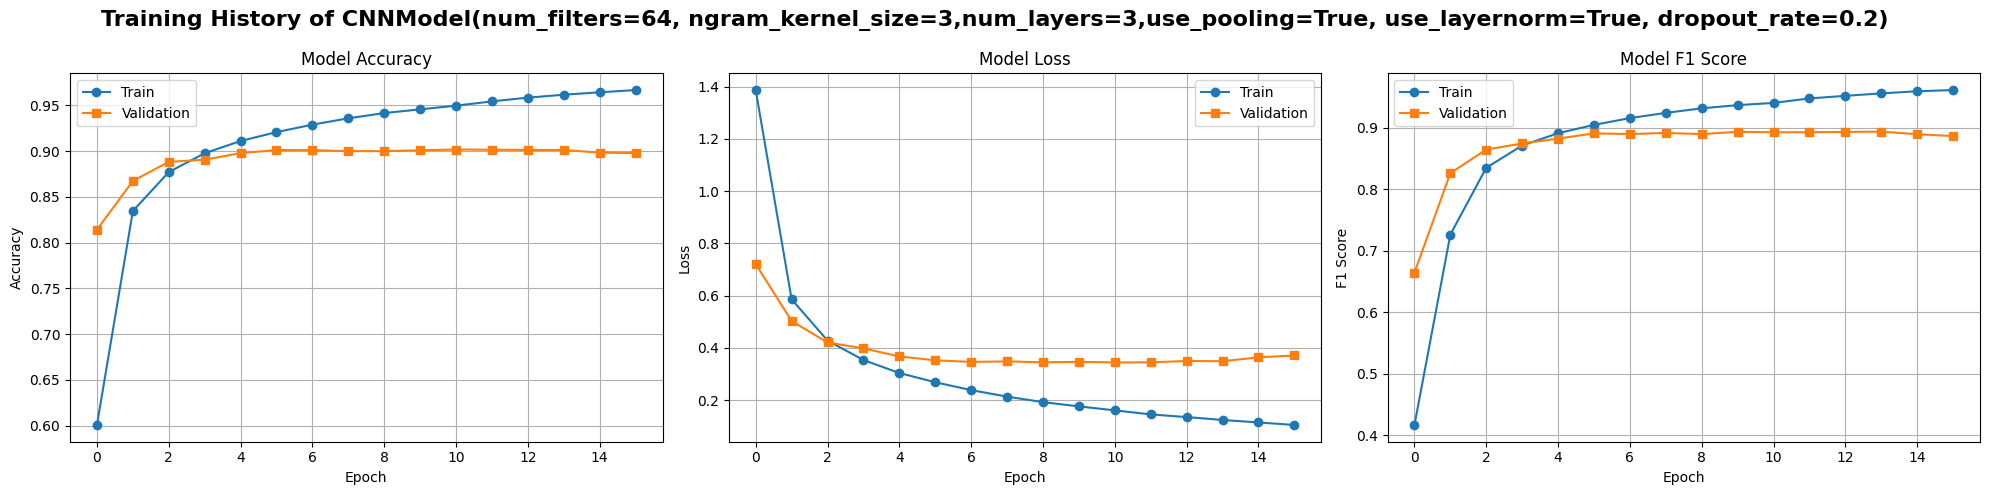

In [ ]:
# DataLoaders with collate_fn
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
#test_loader_unlabeled = DataLoader(test_dataset_competition, batch_size=batch_size,collate_fn=collate_batch, shuffle=False)


epochs = 180
num_classes = len(np.unique(y_train_split))

model5 = CNNModel(vocab_size=len(vocab), embed_dim=300,
                               output_dim=num_classes,
                               num_filters=64, ngram_kernel_size=4,
                               num_layers=3,
                               use_pooling=True, use_layernorm=True, dropout_rate_cnn=0.3)
model5 = model5.float().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.0001)

train_losses5, val_losses5, train_log_losses5, val_log_losses5, train_accuracies5, val_accuracies5, train_f1s5, val_f1s5 = train_model_cnn(
    model5, train_loader, val_loader, criterion, optimizer, device=device, epochs=epochs, patience=5
)

y_true_train5, y_pred_train5, y_prob_train5 = evaluate_model_cnn(model5, train_loader, device)
y_true_val5, y_pred_val5, y_prob_val5 = evaluate_model_cnn(model5, val_loader, device)
y_true_test5, y_pred_test5, y_prob_test5 = evaluate_model_cnn(model5, test_loader, device)

plot_history(train_losses5, val_losses5, train_accuracies5, val_accuracies5, train_f1s5, val_f1s5, model_name="CNNModel(num_filters=64, ngram_kernel_size=3,num_layers=3,use_pooling=True, use_layernorm=True, dropout_rate=0.2)")

In [ ]:
y_true_comp, y_pred_comp, y_prob_comp = evaluate_model_cnn(model5, test_loader_unlabeled, device)
y_true_test, y_pred_test, y_prob_test = evaluate_model_cnn(model5, test_loader, device)
test_mlp_logloss = multiclass_log_loss(y_test, y_prob_test)
print(test_mlp_logloss)

0.3266897266390123


Epoch 1/180 | Train Loss: 2.69520 | Val Loss: 2.53034 |Train Acc: 0.1824 | Val Acc: 0.2570 |Train F1: 0.0630 | Val F1: 0.0531 |Train LogLoss: 2.69549 | Val LogLoss: 2.53095
Epoch 3/180 | Train Loss: 2.31122 | Val Loss: 2.18348 |Train Acc: 0.2985 | Val Acc: 0.3765 |Train F1: 0.1134 | Val F1: 0.1479 |Train LogLoss: 2.31147 | Val LogLoss: 2.18414
Epoch 5/180 | Train Loss: 1.99116 | Val Loss: 1.85332 |Train Acc: 0.4161 | Val Acc: 0.5213 |Train F1: 0.1878 | Val F1: 0.2681 |Train LogLoss: 1.99122 | Val LogLoss: 1.85367
Epoch 7/180 | Train Loss: 1.67603 | Val Loss: 1.55259 |Train Acc: 0.5129 | Val Acc: 0.6093 |Train F1: 0.2728 | Val F1: 0.3562 |Train LogLoss: 1.67593 | Val LogLoss: 1.55309
Epoch 9/180 | Train Loss: 1.40719 | Val Loss: 1.33119 |Train Acc: 0.5916 | Val Acc: 0.6687 |Train F1: 0.3588 | Val F1: 0.4421 |Train LogLoss: 1.40563 | Val LogLoss: 1.33227
Epoch 11/180 | Train Loss: 1.20740 | Val Loss: 1.16559 |Train Acc: 0.6492 | Val Acc: 0.7216 |Train F1: 0.4336 | Val F1: 0.5287 |Train L

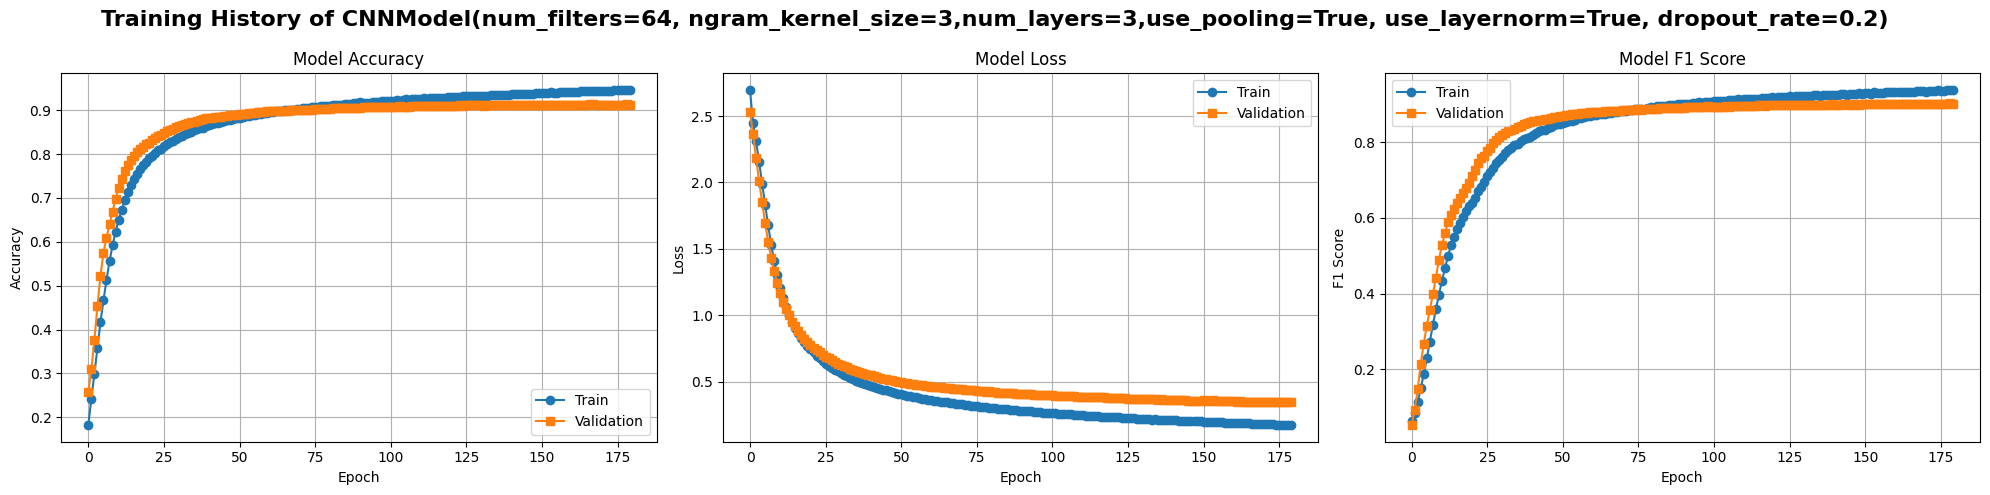

In [ ]:
# DataLoaders with collate_fn
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
#test_loader_unlabeled = DataLoader(test_dataset_competition, batch_size=batch_size,collate_fn=collate_batch, shuffle=False)


epochs = 180
num_classes = len(np.unique(y_train))

model = CNNModel(vocab_size=len(vocab), embed_dim=300,
                               output_dim=num_classes,
                               num_filters=64, ngram_kernel_size=3,
                               num_layers=3,
                               use_pooling=True, use_layernorm=True, dropout_rate_cnn=0.5)
model = model.float().to(device)

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

train_losses, val_losses, train_log_losses, val_log_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = train_model(
    model, train_loader, val_loader, criterion, optimizer, device=device, epochs=epochs, patience=5
)

y_true_train, y_pred_train, y_prob_train = evaluate_model_cnn(model, train_loader, device)
y_true_val, y_pred_val, y_prob_val = evaluate_model_cnn(model, val_loader, device)
y_true_test, y_pred_test, y_prob_test = evaluate_model_cnn(model, test_loader, device)

plot_history(train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s, model_name="CNNModel(num_filters=64, ngram_kernel_size=3,num_layers=3,use_pooling=True, use_layernorm=True, dropout_rate=0.2)")

In [ ]:
y_true_comp, y_pred_comp, y_prob_comp = evaluate_model_cnn(model, test_loader_unlabeled, device)
y_true_test, y_pred_test, y_prob_test = evaluate_model_cnn(model, test_loader, device)
test_mlp_logloss = multiclass_log_loss(y_test, y_prob_test)
print(test_mlp_logloss)

0.3284391795633663


In [ ]:
from sklearn.metrics import classification_report, log_loss

Epoch 1/180 | Train Loss: 0.90839 | Val Loss: 0.46621 |Train Acc: 0.7505 | Val Acc: 0.8712 |Train F1: 0.6333 | Val F1: 0.8329 |Train LogLoss: 0.90858 | Val LogLoss: 0.46667
Epoch 3/180 | Train Loss: 0.33402 | Val Loss: 0.36265 |Train Acc: 0.9056 | Val Acc: 0.8995 |Train F1: 0.8888 | Val F1: 0.8867 |Train LogLoss: 0.33408 | Val LogLoss: 0.36302
Epoch 5/180 | Train Loss: 0.24996 | Val Loss: 0.35884 |Train Acc: 0.9276 | Val Acc: 0.9031 |Train F1: 0.9158 | Val F1: 0.8933 |Train LogLoss: 0.24981 | Val LogLoss: 0.35921
Epoch 7/180 | Train Loss: 0.20008 | Val Loss: 0.36465 |Train Acc: 0.9404 | Val Acc: 0.9025 |Train F1: 0.9323 | Val F1: 0.8960 |Train LogLoss: 0.19988 | Val LogLoss: 0.36503
Epoch 9/180 | Train Loss: 0.16310 | Val Loss: 0.38820 |Train Acc: 0.9508 | Val Acc: 0.9049 |Train F1: 0.9437 | Val F1: 0.8982 |Train LogLoss: 0.16314 | Val LogLoss: 0.38861
Early stopping triggered at epoch 9


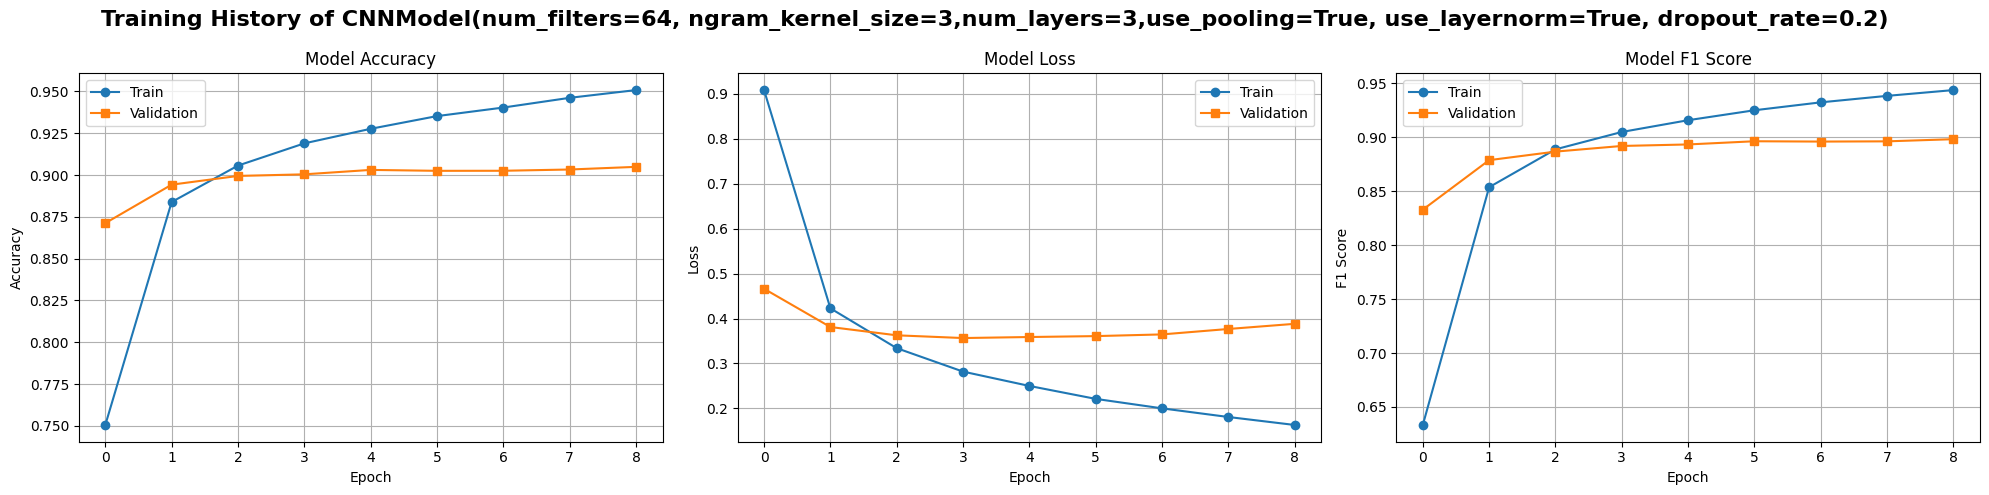

In [ ]:
# DataLoaders with collate_fn
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
#test_loader_unlabeled = DataLoader(test_dataset_competition, batch_size=batch_size,collate_fn=collate_batch, shuffle=False)


epochs = 180
num_classes = len(np.unique(y_train_split))

model1 = CNNModel(vocab_size=len(vocab), embed_dim=300,
                               output_dim=num_classes,
                               num_filters=64, ngram_kernel_size=3,
                               num_layers=3,
                               use_pooling=False, use_attention=True, attention_dim=256,  use_layernorm=True, dropout_rate_cnn=0.3)
model1 = model1.float().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0001)

train_losses1, val_losses1, train_log_losses1, val_log_losses1, train_accuracies1, val_accuracies1, train_f1s1, val_f1s1 = train_model(
    model1, train_loader, val_loader, criterion, optimizer, device=device, epochs=epochs, patience=5
)

y_true_train1, y_pred_train1, y_prob_train1 = evaluate_model_cnn(model1, train_loader, device)
y_true_val1, y_pred_val1, y_prob_val1 = evaluate_model_cnn(model1, val_loader, device)
y_true_test1, y_pred_test1, y_prob_test1 = evaluate_model_cnn(model1, test_loader, device)

plot_history(train_losses1, val_losses1, train_accuracies1, val_accuracies1, train_f1s1, val_f1s1, model_name="CNNModel(num_filters=64, ngram_kernel_size=3,num_layers=3,use_pooling=True, use_layernorm=True, dropout_rate=0.2)")

### **Optimal Data Preprocessing & FastText Embeddings**

In [20]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
    #stratify=y_train  # Ensures class distribution is preserved
)

y_train_split = y_train_split.reset_index(drop=True)
y_val_split = y_val_split.reset_index(drop=True)
y_test_new = y_test.reset_index(drop=True)


In [21]:
# Create custom vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train_split)
custom_vocab = vectorizer.vocabulary_

# Load FastText embeddings using gensim downloader
import gensim.downloader as api
word2vec = api.load('fasttext-wiki-news-subwords-300')  # Limited FastText vectors (no subword inference)

# Map custom vocabulary to FastText indices with 'PAD' and 'UNK' tokens
embedding_dim = 300
average_embedding = np.mean(word2vec.vectors, axis=0)  # average of all embeddings

vocab = {'PAD': 0, 'UNK': 1}
vocab.update({word: idx + 2 for idx, word in enumerate(custom_vocab)})

embedding_matrix = np.zeros((len(vocab), embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token embedding
embedding_matrix[1] = average_embedding         # UNK token embedding

# Fix: Handle missing words with fallback to average_embedding
for word, idx in vocab.items():
    if idx > 1:  # Skip PAD and UNK
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            embedding_matrix[idx] = average_embedding  # fallback for OOV

# Cleanup
del word2vec


[==================================================] 100.0% 958.5/958.4MB downloaded


In [22]:
# Create datasets
train_dataset = TextDataset(X_train_split, y_train_split, vocab)
val_dataset = TextDataset(X_val_split, y_val_split, vocab)
test_dataset = TextDataset(X_test, y_test, vocab)
#test_dataset_competition = TextDataset(test_text_cleaned, torch.zeros(X_tfidf_test_comp.shape[0]), vocab)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Epoch 1/180 | Train Loss: 1.29644 | Val Loss: 0.63180 |Train Acc: 0.6273 | Val Acc: 0.8378 |Train F1: 0.4755 | Val F1: 0.7493 |Train LogLoss: 1.29683 | Val LogLoss: 0.63274
Epoch 3/180 | Train Loss: 0.39961 | Val Loss: 0.40086 |Train Acc: 0.8864 | Val Acc: 0.8932 |Train F1: 0.8556 | Val F1: 0.8779 |Train LogLoss: 0.39954 | Val LogLoss: 0.40127
Epoch 5/180 | Train Loss: 0.29090 | Val Loss: 0.35344 |Train Acc: 0.9155 | Val Acc: 0.9007 |Train F1: 0.8999 | Val F1: 0.8908 |Train LogLoss: 0.29057 | Val LogLoss: 0.35386
Epoch 7/180 | Train Loss: 0.23263 | Val Loss: 0.34245 |Train Acc: 0.9308 | Val Acc: 0.9028 |Train F1: 0.9197 | Val F1: 0.8946 |Train LogLoss: 0.23275 | Val LogLoss: 0.34182
Epoch 9/180 | Train Loss: 0.19410 | Val Loss: 0.32856 |Train Acc: 0.9411 | Val Acc: 0.9045 |Train F1: 0.9330 | Val F1: 0.8953 |Train LogLoss: 0.19420 | Val LogLoss: 0.32909
Epoch 11/180 | Train Loss: 0.16316 | Val Loss: 0.31939 |Train Acc: 0.9499 | Val Acc: 0.9079 |Train F1: 0.9430 | Val F1: 0.8988 |Train L

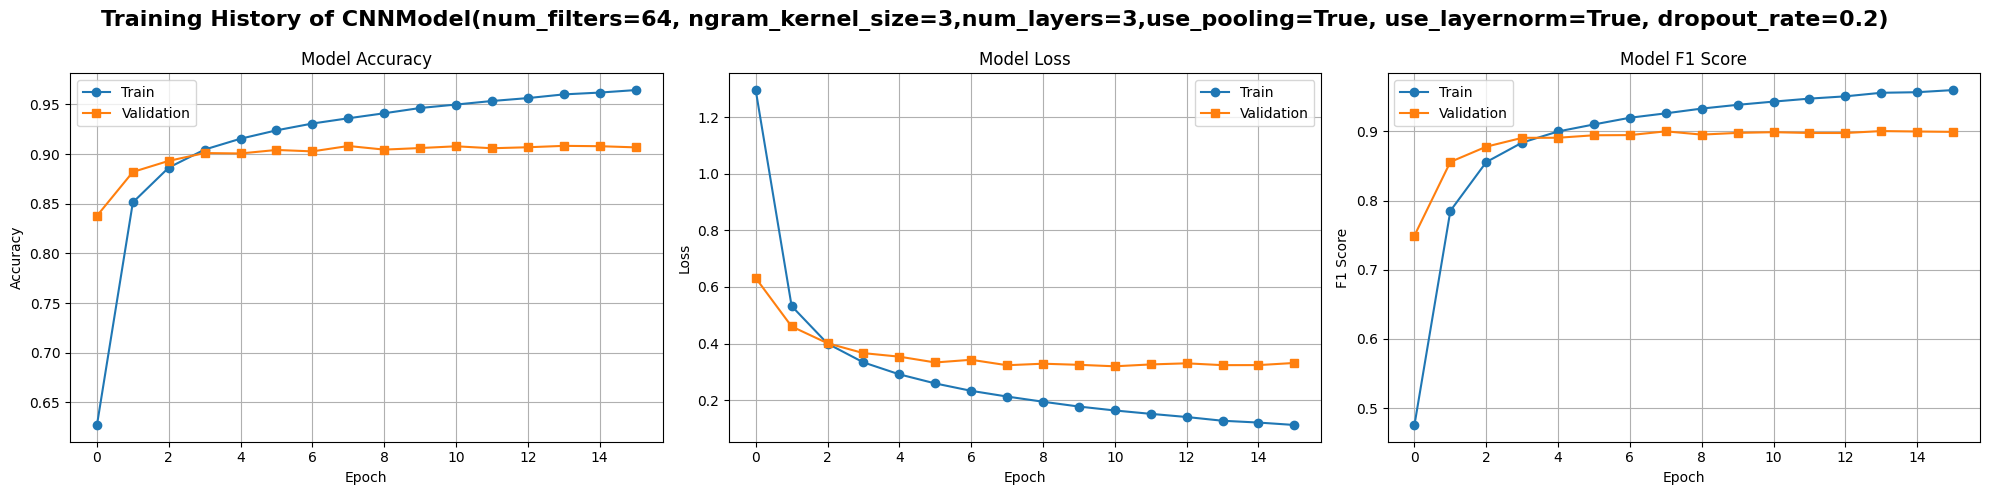

In [26]:
# DataLoaders with collate_fn
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)
#test_loader_unlabeled = DataLoader(test_dataset_competition, batch_size=batch_size,collate_fn=collate_batch, shuffle=False)


epochs = 180
num_classes = len(np.unique(y_train_split))

model5 = CNNModel(vocab_size=len(vocab), embed_dim=300,
                               output_dim=num_classes,
                               num_filters=64, ngram_kernel_size=4,
                               num_layers=3,
                               use_pooling=True, use_layernorm=True, dropout_rate_cnn=0.3)
model5 = model5.float().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.0001)

train_losses5, val_losses5, train_log_losses5, val_log_losses5, train_accuracies5, val_accuracies5, train_f1s5, val_f1s5 = train_model_cnn(
    model5, train_loader, val_loader, criterion, optimizer, device=device, epochs=epochs, patience=5
)

y_true_train5, y_pred_train5, y_prob_train5 = evaluate_model_cnn(model5, train_loader, device)
y_true_val5, y_pred_val5, y_prob_val5 = evaluate_model_cnn(model5, val_loader, device)
y_true_test5, y_pred_test5, y_prob_test5 = evaluate_model_cnn(model5, test_loader, device)

plot_history(train_losses5, val_losses5, train_accuracies5, val_accuracies5, train_f1s5, val_f1s5, model_name="CNNModel(num_filters=64, ngram_kernel_size=3,num_layers=3,use_pooling=True, use_layernorm=True, dropout_rate=0.2)")

- **Test Set Log Loss:** 

In [30]:
y_true, y_pred, y_prob = evaluate_model_cnn(model5, test_loader, device)
y_true_train, y_preb_train, y_prob_train = evaluate_model_cnn(model5, train_loader, device)

custom_loss = multiclass_log_loss(y_test, y_prob)
print(f"Log Loss (CNN-Test): {custom_loss:.4f}")


Log Loss (CNN-Test): 0.3325

Log Loss (CNN-Train): 7.4962


- **Train Set Log Loss:**

In [40]:
y_true_train, y_preb_train, y_prob_train = evaluate_model_cnn(model5, train_loader, device)

custom_loss = multiclass_log_loss(y_train_split, y_prob_train)
print(f"Log Loss (CNN-Train): {custom_loss:.4f}")


Log Loss (CNN-Train): 0.0779


- **Validation Set Log Loss:**

In [36]:
y_true_val, y_preb_val, y_prob_val = evaluate_model_cnn(model5, val_loader, device)

custom_loss = multiclass_log_loss(y_val_split, y_prob_val)
print(f"Log Loss (CNN-Val): {custom_loss:.4f}")


Log Loss (CNN-Val): 0.3319


# **Results**

### 📊 Results on Labeled Test Set
| Setup                  | Log Loss |
|------------------------|----------|
| TF-IDF + SBERT         | 0.2408   |
| TF-IDF + SBERT + PRICE | **0.2384**   |

> ✅ These results are based on the **labeled test set** used for evaluation.


### 🏁 Results on Unlabeled Test Set (Competition)
| Setup                  | Log Loss (Competition) |
|------------------------|------------------------|
| TF-IDF + SBERT         | 0.2488                 |
| TF-IDF + SBERT + PRICE | **0.2516**                 |

> 📌 These results are based on the **unlabeled test set** submitted for **competition evaluation**.


### ⚠️ Observation

Although the optimal setup on the **labeled test set** was the combination of **TF-IDF + SBERT + PRICE**, achieving the **lowest log loss (0.2384)**,  
📉 in the **competition (unlabeled test set)**, the performance **dropped slightly**, and **TF-IDF + SBERT** alone performed better (0.2488 vs. 0.2516).

This suggests that the **added price feature**, while helpful in the internal validation, may not generalize as well to unseen test data.

---

### 🔍 Model Comparison: Log Loss on Labeled Test Set

| Model                       | Features Used         | Test Log Loss |
|----------------------------|-----------------------|----------------|
| **MLP**                    | TF-IDF                | 0.3174         |
| **MLP**                    | TF-IDF + SBERT        | 0.4063         |
| **CNN**                    | FastText Embeddings   | 0.3325          |
| **Calibrated LinearSVC**   | TF-IDF + SBERT        | 0.2408         |
| **Calibrated LinearSVC**   | TF-IDF + SBERT + Price| 0.2384         |

> ⚠️ **Despite anticipating that neural networks (MLP, CNN) would outperform simpler models, the results reveal that the `Calibrated LinearSVC` achieves the lowest log loss on the labeled test set**, outperforming both MLP and CNN architectures.
>
> This underscores the strength of simpler models when paired with strong feature engineering and proper calibration techniques.
